In [1]:
# FUNCTIONS
import numpy as np
import matplotlib.pyplot as plt
import math

def act_func(x, n_HPC):
    result = np.empty_like(x)
    result[:n_HPC] = np.tanh(x[:n_HPC])
    result[n_HPC:] = np.tanh(0.5 * x[n_HPC:])     # from 0.46*x
    return result


def hopfield(x, W, I, n_HPC):
    dxdt = -x + act_func(W @ x + I, n_HPC)
    return dxdt


def hebbian(W, r, learn_rate, decay_rate):
    
    firing_rates = np.copy(r)
    
    # Gating of plasticity avoids noise to be encoded.
    # This is important during the sleep phase, when the network loops over many cycles 
    # and where the 'noisy connections' can become amplified with each cycle.
    
    for j,rate in enumerate(firing_rates):
        if abs(firing_rates[j])<0.4:
            firing_rates[j]=0

    dw = (learn_rate*(1 - W)*np.outer(firing_rates, firing_rates) - decay_rate*W)/len(firing_rates)
    
    return dw

def generate_pattern(Number_units, number_engram_cells ):
    pattern = np.zeros(Number_units)
    pattern[:number_engram_cells] = np.random.choice([-1, 1], size=number_engram_cells).astype(int)
    return pattern


# Function to create connectivity plots
def plot_weights( weights, title, filename, ax=None, ylabel=True):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        ax = ax

    
    # Create a mask for the weights matrix
    mask = np.where(np.abs(weights) < 0.07, 1, 0)  # set entries smaller than 0.07 to 1
      
    color_map = ax.imshow(np.ma.masked_array(weights, mask=mask), extent=[0, weights.shape[0], 0, weights.shape[1]], 
                          vmin=-1, vmax=1, aspect='auto', cmap=cmap)
    
    ax.set_xlabel('(Pre) Neuron #', fontsize=25)
    if ylabel==True:
        ax.set_ylabel('(Post) Neuron #', fontsize=25)
        ytick_positions = np.arange(0, weights.shape[1]+1, weights.shape[1]/2)
        ytick_labels = np.arange(int(weights.shape[1]), -1, int(-weights.shape[1]/2))
        ax.set_yticks(ytick_positions)
        ax.set_yticklabels(ytick_labels, fontsize=18)

        
    elif ylabel==False:
        ax.set_yticks([])
    ax.set_title(title, fontsize=20, pad=15)

    xtick_positions = np.arange(0, weights.shape[0]+1, weights.shape[0]/2) 
    xtick_labels = np.arange(0, weights.shape[0] + 1, int(weights.shape[0] / 2))
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_labels, fontsize=18)
    

def plot_input(state, Input, Input_name, n_total, cmap, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))
    else:
        ax = ax

    for i in range(n_total):
        ax.add_patch(plt.Rectangle((i-0.5, -0.5), 1, 1, fill=False, edgecolor='black'))
    input_cmap = ax.imshow(Input, cmap=cmap, vmin=-1, vmax=1)
    ax.set_title(f'{Input_name}', fontsize=25, pad=15)  
    ax.set_yticks([]) 
    ax.set_xticks([])
    

def plot_RNN(region, state, neuron_positions, r, cmap, circle_radius=0.05, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        ax = ax

    # Draw neurons as circles
    for neuron in range(len(neuron_positions)):
        x, y = neuron_positions[neuron]
        circle = plt.Circle((x, y), radius=circle_radius, edgecolor='black', facecolor='white', linewidth=1)
        ax.add_patch(circle)
        
    # Create a masked array for r
    mask = np.abs(r[0]) < 0.2
    r_masked = np.ma.masked_array(r[0], mask)

    # Use plt.scatter with the masked array to plot the colored points
    sc = ax.scatter([pos[0] for pos in neuron_positions], [pos[1] for pos in neuron_positions],
                 c=r_masked, cmap=cmap, s=150, vmin=-1, vmax=1)
    sc.set_facecolor("white")  # set the color of the masked points to white        

    # Hide axis lines, ticks, and labels
    ax.axis('off')

    # Set aspect ratio to equal so circles are not distorted
    ax.set_aspect('equal')

    ax.set_title(f'{region}', fontsize=20, pad=10, loc='left')


def bar_activity(x, r, ax=None, ylabel=True):
    # Bar graph with states for HPC
    ax.bar(x, r.flatten(), width=1, edgecolor='black', color='grey')
    ax.set_xlabel('Neuron #', fontsize=25)
    if ylabel:
        ax.set_ylabel('Act., $x$', fontsize=25)
        ax.set_yticks([-1, 1])
        ax.set_yticklabels([-1, 1], fontsize=18)
    else:
        ax.set_yticks([])
    ax.set_ylim([-1.2, 1.2])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    
    
    
def get_overlap_array(P, overlap_fraction):  

    #print(pattern)
    indices_non_zero = np.where(np.logical_or(P == -1, P == 1))[0]
    num_non_zero = len(indices_non_zero)
    
    indices_zero = np.where(P == 0)[0]
    num_zero = len(indices_zero)

    num_non_overlap = int(round(num_non_zero * (1-overlap_fraction)))  # Compute number of matching entries
    
    # Initialize overlap array I equal to P
    I = np.copy(P)
    
    # Randomly select indices for non-matching entries
    non_overlap_indices1 =  np.random.choice(indices_non_zero, num_non_overlap, replace=False)
    non_overlap_indices2 =  np.random.choice(indices_zero, num_non_overlap, replace=False)

    # Change non-matching entries in I to be zero or 1
    I[non_overlap_indices1] = 0
    I[non_overlap_indices2] =  np.random.choice([-1, 1], size=num_non_overlap)
    
    return I


def get_recall_input(P, number_act_units):  

    indices_non_zero = np.where(np.logical_or(P == -1, P == 1))[0]
    
    # Randomly select indices for non-matching entries
    non_overlap_entries = np.random.choice(indices_non_zero, size=(10-number_act_units), replace=False)
        
    # Initialize overlap array I equal to P
    I = np.copy(P)
    
    # Change non-matching entries in I to be zero or 1
    I[non_overlap_entries] = 0
    
    return I

import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
colors = ['#273B86', '#2A4090', '#2D449A', '#3149A4', '#344EAE', '#3752B8', '#3A57C2', '#3E5CCD', '#4160D7', '#4660D8', '#5062D9', '#6065D9', '#6A71E1', '#7478E3', '#888BEF', '#9BA3EB', '#BBC1F4', '#DBDFFD', '#EDEFFE', '#FFFFFF',
'#F9F9EE', '#F6EEB7', '#F3E280', '#EDD62E', '#ECCB12', '#EEC711', '#EFC422', '#F0C01B', '#F1BC31', '#E7AE2E', '#DE9A2B', '#D98C18', '#D4821D', '#CB7926', '#C26D24', '#B95821', '#B14E1E', '#AA461D', '#A6371C']

cmap = mcolors.ListedColormap(colors)

neuron_positions = [
    [0.4, 0.9], [0.15, 0.65], [0.6, 0.9], [0.07, 0.5], [0.3, 0.6],[0.21, 0.9], [0.1, 0.8], [0.3, 0.8], [0.5, 0.8], [0.4, 0.72],
    [0.38, 0.45], [0.15, 0.15], [0.85, 0.85], [0.7, 0.4], [0.3, 0.1],[0.21, 0.4], [0.1, 0.3], [0.3, 0.3], [0.55, 0.35], [0.4, 0.22],
    [0.85, 0.35], [0.6, 0.2], [0.8, 0.2], [0.5, 0.5], [0.7, 0.1],[0.61, 0.65], [0.8, 0.6], [0.9, 0.7], [0.5, 0.1], [0.7, 0.75]
]

### Encoding and consolidation of a memory in a naive neural network (Figure 1)

In [2]:
%matplotlib inline

#### Pattern A - Awake stage

In [3]:
n_HPC = 30
n_PFC = 30
n_total = n_HPC + n_PFC

learn_HPC = 0.45
decay_HPC = 0.55
learn_PFC = 0.06  # or 0.06
decay_PFC = 0
dt=0.01

# Connectivity matrix
weights = np.zeros((n_total, n_total))
v1 = [i for i in range(n_HPC, n_total)]
v2 = [i for i in range(0, n_HPC)]
weights[v2,v1]=-1
weights[v1,v2]=0.5

r =  np.zeros(n_total)
r_total = []

P = np.array([-1, 1, -1,  1, -1,-1, 1, -1,  1, -1])
P_zeros = np.zeros(20)
P = np.concatenate((P, P_zeros))
Ext_input = P.reshape(1,n_HPC)
pattern = np.copy(P)
print('pattern to store:', P)
P=np.concatenate((P,P))

i=0

while True:  
    
    weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC)
    weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)  
    
    r_new = r + dt*hopfield(r, weights, P, n_HPC)
    
    r_total.append(r)
    
    if i>7600:
        print(r_new)
        break
        
    i+=1
    r = r_new
    
r_total = list(zip(*r_total))

r_final_HPC = r[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r[n_HPC:].reshape(1,n_HPC)

trained_weights_awake1 = np.copy(weights)


pattern to store: [-1.  1. -1.  1. -1. -1.  1. -1.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[-0.99997087  0.99999372 -0.99997087  0.99999372 -0.99997087 -0.99997087
  0.99999372 -0.99997087  0.99999372 -0.99997087  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.76038693  0.76186116 -0.76038693  0.76186116 -0.76038693 -0.76038693
  0.76186116 -0.76038693  0.76186116 -0.76038693  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]


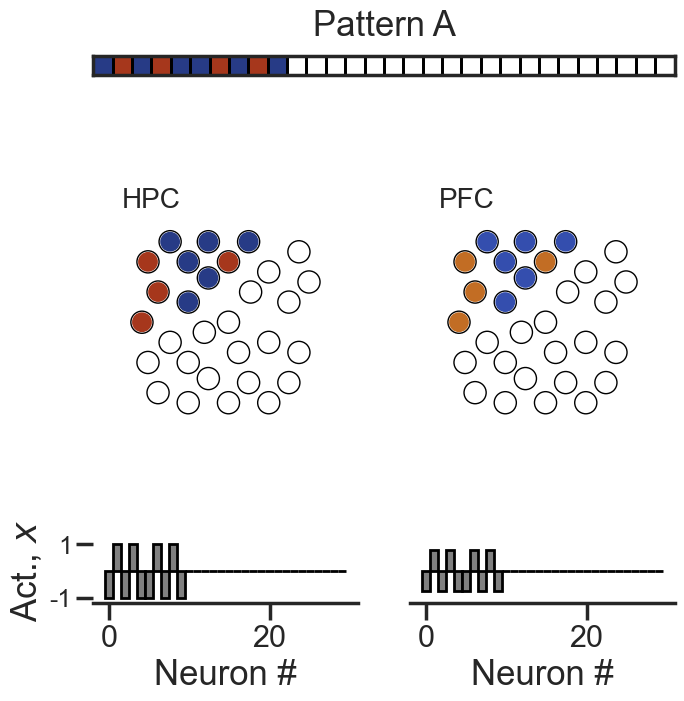

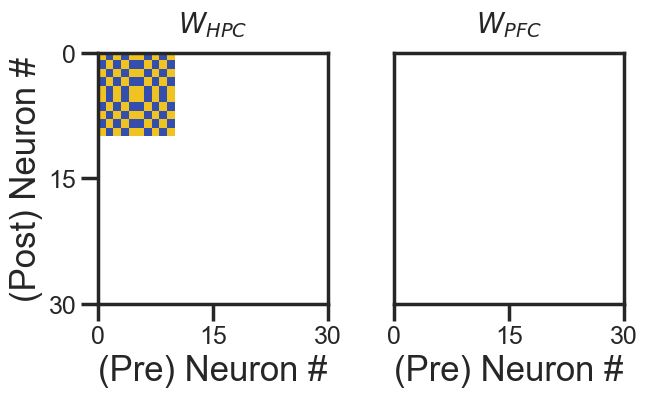

In [4]:
# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set(style='white')
sns.set_style('ticks')
sns.set_context('poster')


# Figure 1 a)
fig = plt.figure(figsize=(7.5, 7.5))
grid = plt.GridSpec(3, 2, hspace=1, width_ratios=[1, 1], height_ratios=[1, 2.5, 0.8])

ax_input = fig.add_subplot(grid[0, :])
plot_input('awake1', Ext_input, 'Pattern A', n_total, cmap, ax=ax_input)

ax_rnn_hpc = fig.add_subplot(grid[1, 0])
plot_RNN('HPC', 'awake1', neuron_positions, r_final_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

ax_rnn_pfc = fig.add_subplot(grid[1, 1])
plot_RNN('PFC', 'awake1', neuron_positions, r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for HPC
x = np.arange(n_HPC)
ax_bar_hpc = fig.add_subplot(grid[2, 0])
bar_activity(x,r_final_HPC, ax=ax_bar_hpc, ylabel=True)


# Bar graph with states for PFC
ax_bar_pfc = fig.add_subplot(grid[2, 1])
bar_activity(x, r_final_PFC, ax=ax_bar_pfc, ylabel=False)


# Adjust layout and save the figure
plt.savefig('Figure1_a.png', dpi=600, transparent=True)
plt.show

# Figure 1 b)
fig = plt.figure(figsize=(7, 4.5))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights[:n_HPC, :n_HPC], '$W_{HPC}$', 'Trained_wHPC_sleep1.png', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights[n_HPC:, n_HPC:], '$W_{PFC}$', 'Trained_wPFC_sleep1.png', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure1_b.png', dpi=600, transparent=True)
plt.show()


#### Pattern A - Sleeping stage

0
1
2
3
4
5
6


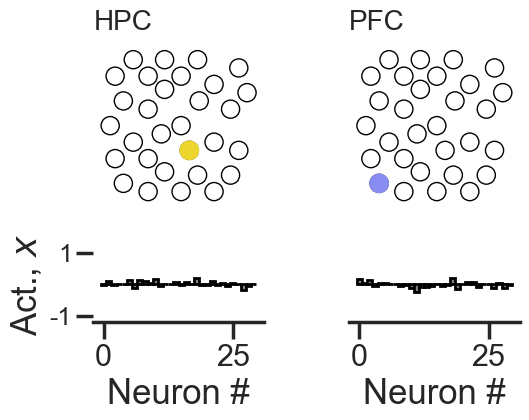

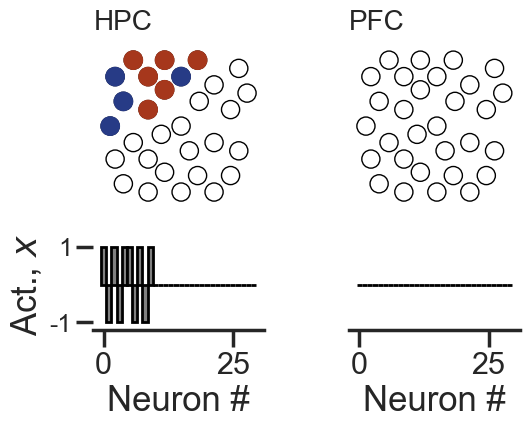

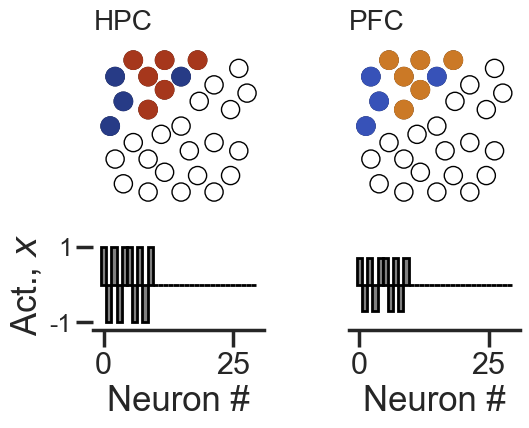

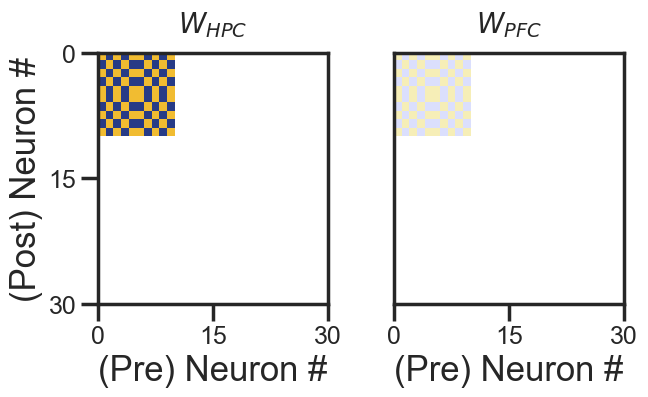

In [5]:
weights = np.copy(trained_weights_awake1)
#r =  np.random.normal(loc=0, scale=0.2, size=n_total)
v1 = [i for i in range(n_HPC, n_total)]
v2 = [i for i in range(0, n_HPC)]
weights[v2,v1]=0 # HPC projects to PFC with one-to-one connections. it works if it is -1 too.

for j in range(7):

    print(j)

    r =  np.random.normal(loc=0, scale=0.1, size=n_total)
    
    if j==0:
        r_init_HPC = r[:n_HPC].reshape(1,n_HPC)
        r_init_PFC = r[n_HPC:].reshape(1,n_HPC)
        
        # Figure 1 c1)
        fig = plt.figure(figsize=(5.5, 5))
        grid = plt.GridSpec(2, 2, hspace=-0.3, wspace=0.5, width_ratios=[1, 1], height_ratios=[1, 0.2])

        ax_rnn_hpc = fig.add_subplot(grid[0, 0])
        plot_RNN('HPC', 'sleep1_phase1', neuron_positions, r_init_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

        ax_rnn_pfc = fig.add_subplot(grid[0, 1])
        plot_RNN('PFC', 'sleep1_phase1', neuron_positions, r_init_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)
        
        # Bar graph with states for HPC
        ax_bar_hpc = fig.add_subplot(grid[1, 0])
        bar_activity(x,r_init_HPC, ax=ax_bar_hpc, ylabel=True)

        # Bar graph with states for PFC
        ax_bar_pfc = fig.add_subplot(grid[1, 1])
        bar_activity(x,r_init_PFC, ax=ax_bar_pfc, ylabel=False)

        plt.savefig('Figure1_c1.png', dpi=600, transparent=True, bbox_inches='tight')

    
    r_total = []

    i=0

    while True:  
    
    # in a first sleep phase, the HPC and PFC are uncoupled. 
    # During this phase, the HPC, starting from a noisy state, converges to its attractor and replays activity experienced during awake.
    # When it reaches the attractor state, the activity of the network is high (in particular of the engram cells)
    # at this stage, we couple the 2 regions (unidirectionally). 
    # adding inhibitory connections from PFC is not necessary but then won't change the result either. 
        if j==0:
            if i==9000:
                r_HPC = r[:n_HPC].reshape(1,n_HPC)
                r_PFC = r[n_HPC:].reshape(1,n_HPC)
        
                # Figure 1 c1)
                fig = plt.figure(figsize=(5.5, 5))
                grid = plt.GridSpec(2, 2, hspace=-0.3,wspace=0.5, width_ratios=[1, 1], height_ratios=[2, 0.5])

                ax_rnn_hpc = fig.add_subplot(grid[0, 0])
                plot_RNN('HPC', 'sleep1_phase1', neuron_positions, r_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

                ax_rnn_pfc = fig.add_subplot(grid[0, 1])
                plot_RNN('PFC', 'sleep1_phase1', neuron_positions, r_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

                # Bar graph with states for HPC
                ax_bar_hpc = fig.add_subplot(grid[1, 0])
                bar_activity(x,r_HPC, ax=ax_bar_hpc, ylabel=True)

                # Bar graph with states for PFC
                ax_bar_pfc = fig.add_subplot(grid[1, 1])
                bar_activity(x,r_PFC, ax=ax_bar_pfc, ylabel=False)

                # Adjust layout and save the figure
                plt.savefig('Figure1_c2.png', dpi=600, transparent=True, bbox_inches='tight')
        
    
        if i>9000:
            weights[v1,v2]=1
            weights[v2,v1]=-1
        else:
            weights[v1,v2]=0
            weights[v2,v1]=0
    
    
        weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC) 
        weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)
    
        r_new = r + dt*hopfield(r, weights, 0, n_HPC)
    
        r_total.append(r)
    

        if i>9900: # from 3100 
            #print(r_new)
            break
        
        i+=1
        r = r_new
    
r_total = list(zip(*r_total))

trained_weights_sleep1 = np.copy(weights)

r_final_HPC = r[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r[n_HPC:].reshape(1,n_HPC)


# Plots 
# Figure 1 c3)
fig = plt.figure(figsize=(5.5, 5))
grid = plt.GridSpec(2, 2, hspace=-0.3,wspace=0.5, width_ratios=[1, 1], height_ratios=[2, 0.5])

ax_rnn_hpc = fig.add_subplot(grid[0, 0])
plot_RNN('HPC', 'sleep1_phase2', neuron_positions, r_final_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

ax_rnn_pfc = fig.add_subplot(grid[0, 1])
plot_RNN('PFC', 'sleep1_phase2', neuron_positions, r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for HPC
ax_bar_hpc = fig.add_subplot(grid[1, 0])
bar_activity(x,r_final_HPC, ax=ax_bar_hpc, ylabel=True)

# Bar graph with states for PFC
ax_bar_pfc = fig.add_subplot(grid[1, 1])
bar_activity(x,r_final_PFC, ax=ax_bar_pfc, ylabel=False)

# Adjust layout and save the figure
plt.savefig('Figure1_c3.png', dpi=600, transparent=True,  bbox_inches='tight')
plt.show


# Figure 1 d)
fig = plt.figure(figsize=(7, 4.5))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights[:n_HPC, :n_HPC], '$W_{HPC}$', 'Trained_wHPC_sleep1.png', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights[n_HPC:, n_HPC:], '$W_{PFC}$', 'Trained_wPFC_sleep1.png', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure1_d.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()



PFC_trained_weights_sleep1 = np.copy(weights[n_HPC:,n_HPC:])

### Recall pattern A (Figure S1)

'Argument' for recall: activity of all units of engram to be >=0.2

(30,)
[ 0.          0.          0.          0.76159416 -0.76159416 -0.76159416
  0.76159416 -0.76159416  0.76159416 -0.76159416  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.2822705   0.2877057  -0.2822705   0.66183007 -0.65849254 -0.65849254
  0.66183007 -0.65849254  0.66183007 -0.65849254  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]


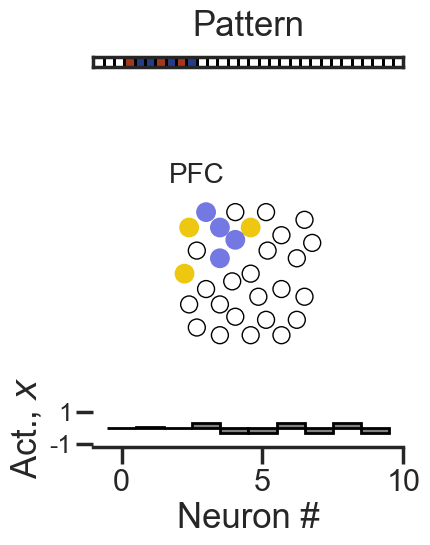

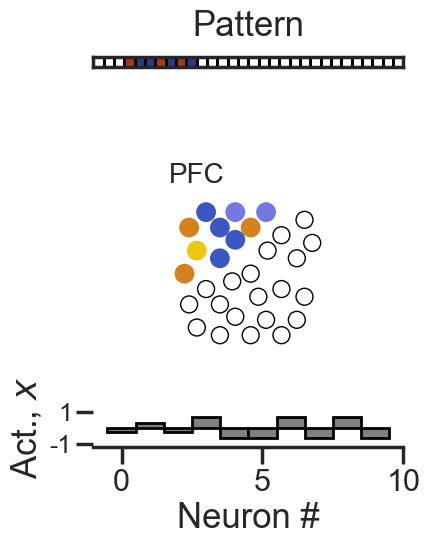

In [6]:
def plot_fr(r_total, targeted_neurons):
    abs_r_total = np.abs(r_total)
    
    fig, ax = plt.subplots(10, 1, figsize=(4,15))
    
    for j,n in enumerate(targeted_neurons):
        iterations = np.arange(len(r_total[n]))
    
        ax[j].spines['top'].set_visible(False)
        ax[j].spines['right'].set_visible(False)
        ax[j].spines['left'].set_visible(False)
        ax[j].xaxis.tick_bottom()
        ax[j].set_xticks([])
        ax[j].set_yticks([])
        ax[j].set_ylim([-0.2, 1.2])
        ax[j].plot(abs_r_total[n+30][:], color='#335781', linewidth=4, label='PFC')
        ax[j].fill_between(iterations, abs_r_total[n+30][:], 0, alpha=0.2, color='#335781')
        if j!=9:
            ax[j].spines['bottom'].set_visible(False)
        else:
            ax[j].set_xlabel('Iteration #, Awake stage')
            ax[j].set_xticks([0,7600])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.savefig('inputBneurons_90overlap.png', bbox_inches='tight', dpi=600, transparent=True)
    plt.show()


# Connectivity matrix
weights = np.zeros((n_total, n_total))
weights[n_HPC:,n_HPC:] = PFC_trained_weights_sleep1 # set weights of R2(PFC) to trained weights

r =  np.zeros(n_total)
r_total = []

#P = generate_pattern(n_HPC, 5) # input pattern
I = np.array([0, 0, 0,  1, -1,-1, 1, -1,  1, -1])
I_zeros = np.zeros(20)
I = np.concatenate((I, I_zeros))
Ext_input = I.reshape(1,n_HPC)
I=np.concatenate((I,I))

i=0

while True:  
        
    if i==90: 

        r_init_HPC = r[:n_HPC].reshape(1,n_HPC)
        r_init_PFC = r[n_HPC:].reshape(1,n_HPC)
        
        fig = plt.figure(figsize=(4, 6))
        grid = plt.GridSpec(3, 1, hspace=0.5, height_ratios=[2, 2, 0.5])
        
        ax_input = fig.add_subplot(grid[0, 0])
        plot_input('awake1', Ext_input, 'Pattern', n_total, cmap, ax=ax_input)
                
        ax_rnn_pfc = fig.add_subplot(grid[1, 0])
        plot_RNN('PFC', 'sleep1_phase2', neuron_positions, r_init_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

        # Bar graph with states for PFC
        ax_bar_pfc = fig.add_subplot(grid[2, 0])
        print(np.shape(x))
        bar_activity(x[:10],r_init_PFC[0,:10], ax=ax_bar_pfc)

        # Adjust layout and save the figure
        plt.savefig('FigureSup1_a.png', dpi=600, transparent=True,  bbox_inches='tight')
        plt.show
 
        
    r_new = r + dt*hopfield(r, weights, I, n_HPC)
    
    r_total.append(r)
    
    if i>7000:
        print(r_new)
        break
        
    i+=1
    r = r_new


r_total = list(zip(*r_total))

r_final_HPC = r[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r[n_HPC:].reshape(1,n_HPC)


# Plots
# Figure Sup1
fig = plt.figure(figsize=(4, 6))
grid = plt.GridSpec(3, 1, hspace=0.5,height_ratios=[2, 2, 0.5])

ax_input = fig.add_subplot(grid[0, 0])
plot_input('awake1', Ext_input, 'Pattern', n_total, cmap, ax=ax_input)

ax_rnn_pfc = fig.add_subplot(grid[1, 0])
plot_RNN('PFC', 'sleep1_phase2', neuron_positions, r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for PFC
ax_bar_pfc = fig.add_subplot(grid[2, 0])
bar_activity(x[:10],r_final_PFC[0,:10], ax=ax_bar_pfc)

# Adjust layout and save the figure
plt.savefig('FigureSup1_b.png', dpi=600, transparent=True,  bbox_inches='tight')
plt.show





trained_weights_awake1 = np.copy(weights)


### Consolidation of novel memory pattern relies on hippocampal replay during sleep (Figure 2)


#### (Novel) Pattern B - Awake stage

In [7]:
# Connectivity matrix
weights = np.zeros((n_total, n_total))
weights[n_HPC:,n_HPC:] = PFC_trained_weights_sleep1 # set weights of R2(PFC) to trained weights
weights[v2,v1]=-1
weights[v1,v2]=0.5

r =  np.zeros(n_total)
r_total = []


I = get_overlap_array(pattern, 0)
print(I)
New_input = I.reshape(1,n_HPC)
I=np.concatenate((I,I))

i=0

while True: 
    

    weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC)
    weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)

    r_new = r + dt*hopfield(r, weights, I, n_HPC)
    
    r_total.append(r)
    
    if i>7600:
        print(r_new)
        break
        
    i+=1
    r = r_new
    
r_total = list(zip(*r_total))


r_final_HPC = r[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r[n_HPC:].reshape(1,n_HPC)



[[ 0.10120591 -0.11287484  0.10120591 -0.11287484  0.10120591  0.10120591
  -0.11287484  0.10120591 -0.11287484  0.10120591  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [-0.11287484  0.10166074 -0.11287484  0.10166074 -0.11287484 -0.11287484
   0.10166074 -0.11287484  0.10166074 -0.11287484  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.10120591 -0.11287484  0.10120591 -0.11287484  0.10120591  0.10120591
  -0.11287484  0.10120591 -0.11287484  0.10120591  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.     

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.99998653
 -0.99998653  0.          0.          0.          0.99998653  0.99998653
  0.         -0.99998653  0.          0.         -0.99998653  0.
  0.99998653  0.          0.99998653  0.99998653  0.         -0.99998653
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.76117432
 -0.76117432  0.          0.          0.          0.76117432  0.76117432
  0.         -0.76117432  0.          0.         -0.76117432  0.
  0.76117432  0.          0.76117432  0.76117432  0.         -0.76117432]


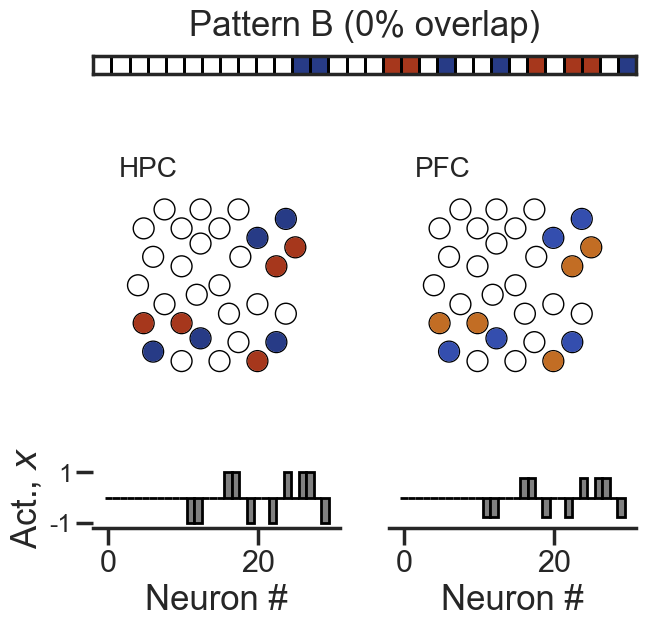

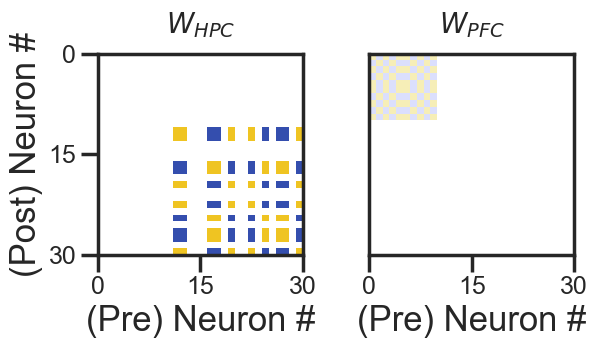

In [8]:
# Figure 2 a)
fig = plt.figure(figsize=(7, 6.5))
grid = plt.GridSpec(3, 2, hspace=0.8, width_ratios=[1, 1], height_ratios=[1, 2.5, 0.8])

ax_input = fig.add_subplot(grid[0, :])
plot_input('awake1', New_input, 'Pattern B (0% overlap)', n_total, cmap, ax=ax_input)

ax_rnn_hpc = fig.add_subplot(grid[1, 0])
plot_RNN('HPC', 'awake1', neuron_positions, r_final_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

ax_rnn_pfc = fig.add_subplot(grid[1, 1])
plot_RNN('PFC', 'awake1', neuron_positions, r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for HPC
x = np.arange(n_HPC)
ax_bar_hpc = fig.add_subplot(grid[2, 0])
bar_activity(x,r_final_HPC, ax=ax_bar_hpc, ylabel=True)


# Bar graph with states for PFC
ax_bar_pfc = fig.add_subplot(grid[2, 1])
bar_activity(x, r_final_PFC, ax=ax_bar_pfc, ylabel=False)


# Adjust layout and save the figure
plt.savefig('Figure2_a.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show

# Figure 1 b)
fig = plt.figure(figsize=(6.5, 4))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights[:n_HPC, :n_HPC], '$W_{HPC}$', 'Trained_wHPC_sleep1.png', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights[n_HPC:, n_HPC:], '$W_{PFC}$', 'Trained_wPFC_sleep1.png', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure2_b.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()


#### (Novel) Pattern B - Sleeping stage

0
1
2
3
4
5
6


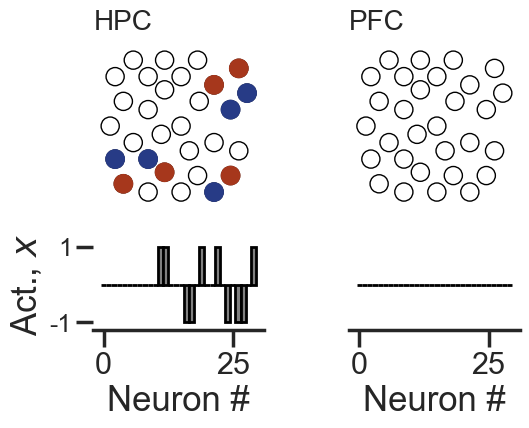

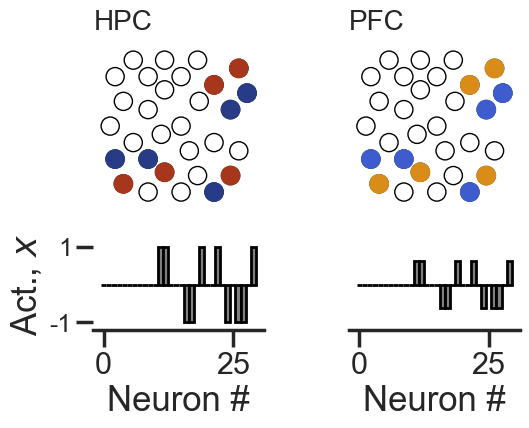

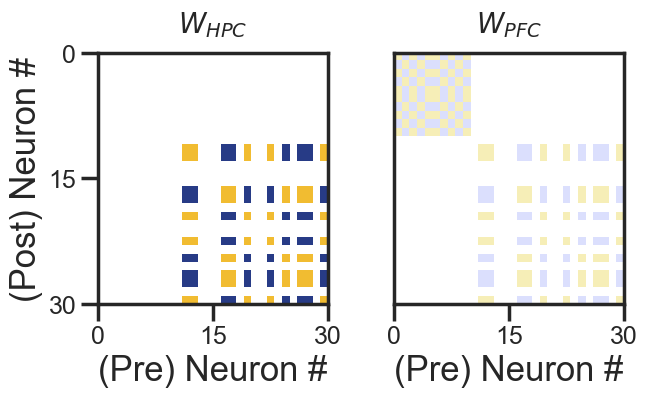

In [9]:
v1 = [i for i in range(n_HPC, n_total)]
v2 = [i for i in range(0, n_HPC)]
weights[v2,v1]=0 # HPC projects to PFC with one-to-one connections. it works if it is -1 too.

for j in range(7):

    print(j)

    r =  np.random.normal(loc=0, scale=0.1, size=n_total)

    
    r_total = []

    i=0

    while True:  
    
    # in a first sleep phase, the HPC and PFC are uncoupled. 
    # During this phase, the HPC, starting from a noisy state, converges to its attractor and replays activity experienced during awake.
    # When it reaches the attractor state, the activity of the network is high (in particular of the engram cells)
    # at this stage, we couple the 2 regions (unidirectionally). 
    # adding inhibitory connections from PFC is not necessary but then won't change the result either. 
        if j==0:
            if i==9000:
                r_HPC = r[:n_HPC].reshape(1,n_HPC)
                r_PFC = r[n_HPC:].reshape(1,n_HPC)
        
                # Figure 1 c1)
                fig = plt.figure(figsize=(5.5, 5))
                grid = plt.GridSpec(2, 2, hspace=-0.3,wspace=0.5, width_ratios=[1, 1], height_ratios=[2, 0.5])

                ax_rnn_hpc = fig.add_subplot(grid[0, 0])
                plot_RNN('HPC', 'sleep1_phase1', neuron_positions, r_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

                ax_rnn_pfc = fig.add_subplot(grid[0, 1])
                plot_RNN('PFC', 'sleep1_phase1', neuron_positions, r_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

                # Bar graph with states for HPC
                ax_bar_hpc = fig.add_subplot(grid[1, 0])
                bar_activity(x,r_HPC, ax=ax_bar_hpc, ylabel=True)

                # Bar graph with states for PFC
                ax_bar_pfc = fig.add_subplot(grid[1, 1])
                bar_activity(x,r_PFC, ax=ax_bar_pfc, ylabel=False)

                # Adjust layout and save the figure
                plt.savefig('Figure2_b2_endREM.png', dpi=600, transparent=True, bbox_inches='tight') 
                
                
            if i==9900:
                r_HPC = r[:n_HPC].reshape(1,n_HPC)
                r_PFC = r[n_HPC:].reshape(1,n_HPC)
        
                # Figure 1 c1)
                fig = plt.figure(figsize=(5.5, 5))
                grid = plt.GridSpec(2, 2, hspace=-0.3,wspace=0.5, width_ratios=[1, 1], height_ratios=[2, 0.5])

                ax_rnn_hpc = fig.add_subplot(grid[0, 0])
                plot_RNN('HPC', 'sleep1_phase1', neuron_positions, r_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

                ax_rnn_pfc = fig.add_subplot(grid[0, 1])
                plot_RNN('PFC', 'sleep1_phase1', neuron_positions, r_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

                # Bar graph with states for HPC
                ax_bar_hpc = fig.add_subplot(grid[1, 0])
                bar_activity(x,r_HPC, ax=ax_bar_hpc, ylabel=True)

                # Bar graph with states for PFC
                ax_bar_pfc = fig.add_subplot(grid[1, 1])
                bar_activity(x,r_PFC, ax=ax_bar_pfc, ylabel=False)

                # Adjust layout and save the figure
                plt.savefig('Figure2_b2_endNREM.png', dpi=600, transparent=True, bbox_inches='tight') 
    
        if i>9000:
            weights[v1,v2]=1
            weights[v2,v1]=-1
        else:
            weights[v1,v2]=0
            weights[v2,v1]=0
    
    
        weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC) 
        weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)
    
        r_new = r + dt*hopfield(r, weights, 0, n_HPC)
    
        r_total.append(r)
    

        if i>9900:
            break
        
        i+=1
        r = r_new
    
r_total = list(zip(*r_total))

r_final_HPC = r[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r[n_HPC:].reshape(1,n_HPC)

# Figure 2 b2)
fig = plt.figure(figsize=(7, 4.5))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights[:n_HPC, :n_HPC], '$W_{HPC}$', 'Trained_wHPC_sleep1.png', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights[n_HPC:, n_HPC:], '$W_{PFC}$', 'Trained_wPFC_sleep1.png', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure2_b2.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()



### Familiar pattern is quickly stored during wakefulness (Figure 3)

#### (Familiar) pattern B - Awake stage


In [10]:
# Connectivity matrix
weights = np.zeros((n_total, n_total))
weights[n_HPC:,n_HPC:] = PFC_trained_weights_sleep1 # set weights of R2(PFC) to trained weights
print(weights[n_HPC:,n_HPC:])
weights[v2,v1]=-1
weights[v1,v2]=0.5

r =  np.zeros(n_total)
r_total = []


#I = get_overlap_array(pattern, 0.9)
#print(I)
I = np.array([-1,  1, -1,  1, -1, -1,  0, -1,  1, -1,  0,  0,  0,  0,  0,  0, -1,  0,
  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
New_input = I.reshape(1,n_HPC)
I=np.concatenate((I,I))

i=0

while True: 
    

    weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC)
    weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)

    r_new = r + dt*hopfield(r, weights, I, n_HPC)
    
    r_total.append(r)
    
    if i>7600:
        print(r_new)
        print(weights[n_HPC:,n_HPC:])
        break
        
    i+=1
    r = r_new
    
r_total = list(zip(*r_total))


r_final_HPC = r[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r[n_HPC:].reshape(1,n_HPC)


[[ 0.10120591 -0.11287484  0.10120591 -0.11287484  0.10120591  0.10120591
  -0.11287484  0.10120591 -0.11287484  0.10120591  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [-0.11287484  0.10166074 -0.11287484  0.10166074 -0.11287484 -0.11287484
   0.10166074 -0.11287484  0.10166074 -0.11287484  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.10120591 -0.11287484  0.10120591 -0.11287484  0.10120591  0.10120591
  -0.11287484  0.10120591 -0.11287484  0.10120591  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.     

[-0.12889097  0.1169049  -0.12889097  0.1169049  -0.12889097 -0.12889097
 -0.33499174 -0.12889097  0.1169049  -0.12889097  0.          0.
  0.          0.          0.          0.         -0.29856744  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.87420135  0.88640022 -0.87420135  0.88640022 -0.87420135 -0.87420135
  0.3491123  -0.87420135  0.88640022 -0.87420135  0.          0.
  0.          0.          0.          0.         -0.70621387  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
[[ 0.18323307 -0.22591207  0.18323307 -0.22591207  0.18323307  0.18323307
  -0.11287484  0.18323307 -0.22591207  0.18323307  0.          0.
   0.          0.          0.          0.          0.07132635  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.

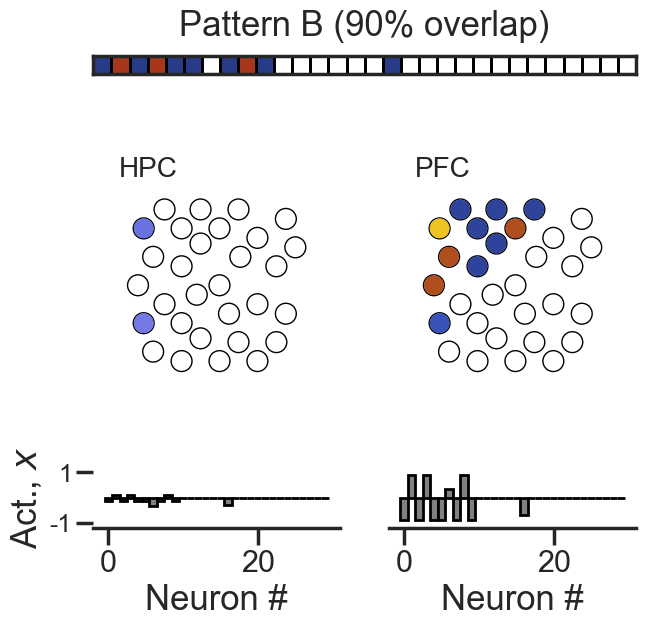

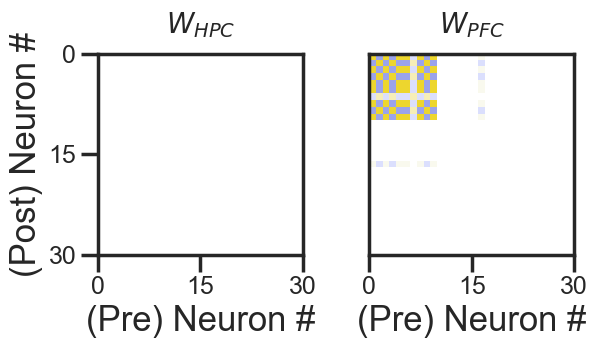

In [11]:
# Figure 3 a)
fig = plt.figure(figsize=(7, 6.5))
grid = plt.GridSpec(3, 2, hspace=0.8, width_ratios=[1, 1], height_ratios=[1, 2.5, 0.8])

ax_input = fig.add_subplot(grid[0, :])
plot_input('awake1', New_input, 'Pattern B (90% overlap)', n_total, cmap, ax=ax_input)

ax_rnn_hpc = fig.add_subplot(grid[1, 0])
plot_RNN('HPC', 'awake1', neuron_positions, r_final_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

ax_rnn_pfc = fig.add_subplot(grid[1, 1])
plot_RNN('PFC', 'awake1', neuron_positions, r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for HPC
x = np.arange(n_HPC)
ax_bar_hpc = fig.add_subplot(grid[2, 0])
bar_activity(x,r_final_HPC, ax=ax_bar_hpc, ylabel=True)


# Bar graph with states for PFC
ax_bar_pfc = fig.add_subplot(grid[2, 1])
bar_activity(x, r_final_PFC, ax=ax_bar_pfc, ylabel=False)

# Adjust layout and save the figure
plt.savefig('Figure3_a1.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show

# Figure 3 b)
fig = plt.figure(figsize=(6.5, 4))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights[:n_HPC, :n_HPC], '$W_{HPC}$', 'Trained_wHPC_sleep1.png', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights[n_HPC:, n_HPC:], '$W_{PFC}$', 'Trained_wPFC_sleep1.png', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure3_a2.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()

#### (Familiar) pattern B - Sleeping stage

0
1
2
3
4
5
6


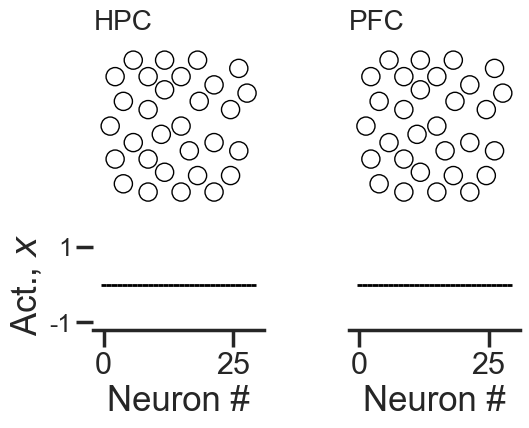

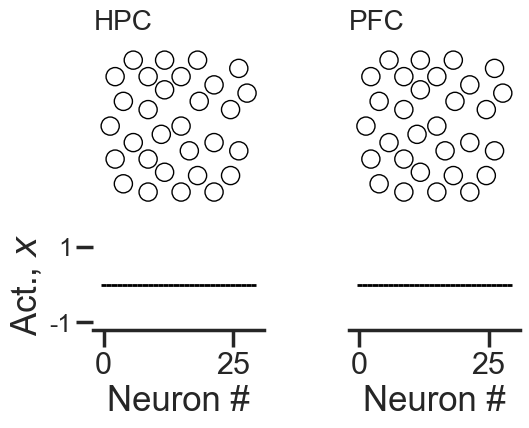

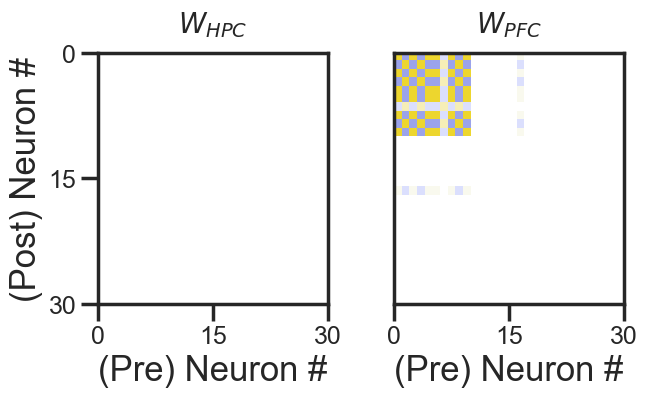

In [12]:
v1 = [i for i in range(n_HPC, n_total)]
v2 = [i for i in range(0, n_HPC)]
weights[v2,v1]=0 # HPC projects to PFC with one-to-one connections. it works if it is -1 too.

for j in range(7):

    print(j)

    r =  np.random.normal(loc=0, scale=0.1, size=n_total)
   
    r_total = []

    i=0

    while True:  
    
    # in a first sleep phase, the HPC and PFC are uncoupled. 
    # During this phase, the HPC, starting from a noisy state, converges to its attractor and replays activity experienced during awake.
    # When it reaches the attractor state, the activity of the network is high (in particular of the engram cells)
    # at this stage, we couple the 2 regions (unidirectionally). 
    # adding inhibitory connections from PFC is not necessary but then won't change the result either. 
        if j==0:
            if i==9000:
                r_HPC = r[:n_HPC].reshape(1,n_HPC)
                r_PFC = r[n_HPC:].reshape(1,n_HPC)
        
                # Figure 1 c1)
                fig = plt.figure(figsize=(5.5, 5))
                grid = plt.GridSpec(2, 2, hspace=-0.3,wspace=0.5, width_ratios=[1, 1], height_ratios=[2, 0.5])

                ax_rnn_hpc = fig.add_subplot(grid[0, 0])
                plot_RNN('HPC', 'sleep1_phase1', neuron_positions, r_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

                ax_rnn_pfc = fig.add_subplot(grid[0, 1])
                plot_RNN('PFC', 'sleep1_phase1', neuron_positions, r_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

                # Bar graph with states for HPC
                ax_bar_hpc = fig.add_subplot(grid[1, 0])
                bar_activity(x,r_HPC, ax=ax_bar_hpc, ylabel=True)

                # Bar graph with states for PFC
                ax_bar_pfc = fig.add_subplot(grid[1, 1])
                bar_activity(x,r_PFC, ax=ax_bar_pfc, ylabel=False)

                # Adjust layout and save the figure
                plt.savefig('Figure3_b1_endREM.png', dpi=600, transparent=True, bbox_inches='tight') 
                
                
            if i==9900:
                r_HPC = r[:n_HPC].reshape(1,n_HPC)
                r_PFC = r[n_HPC:].reshape(1,n_HPC)
        
                # Figure 1 c1)
                fig = plt.figure(figsize=(5.5, 5))
                grid = plt.GridSpec(2, 2, hspace=-0.3,wspace=0.5, width_ratios=[1, 1], height_ratios=[2, 0.5])

                ax_rnn_hpc = fig.add_subplot(grid[0, 0])
                plot_RNN('HPC', 'sleep1_phase1', neuron_positions, r_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

                ax_rnn_pfc = fig.add_subplot(grid[0, 1])
                plot_RNN('PFC', 'sleep1_phase1', neuron_positions, r_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

                # Bar graph with states for HPC
                ax_bar_hpc = fig.add_subplot(grid[1, 0])
                bar_activity(x,r_HPC, ax=ax_bar_hpc, ylabel=True)

                # Bar graph with states for PFC
                ax_bar_pfc = fig.add_subplot(grid[1, 1])
                bar_activity(x,r_PFC, ax=ax_bar_pfc, ylabel=False)

                # Adjust layout and save the figure
                plt.savefig('Figure3_b1_endNREM.png', dpi=600, transparent=True, bbox_inches='tight') 
    
        if i>9000:
            weights[v1,v2]=1
            weights[v2,v1]=-1
        else:
            weights[v1,v2]=0
            weights[v2,v1]=0
    
    
        weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC) 
        weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)
    
        r_new = r + dt*hopfield(r, weights, 0, n_HPC)
    
        r_total.append(r)
    

        if i>9900: 
            break
        
        i+=1
        r = r_new
    
r_total = list(zip(*r_total))

r_final_HPC = r[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r[n_HPC:].reshape(1,n_HPC)



# Figure 2 b2)
fig = plt.figure(figsize=(7, 4.5))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights[:n_HPC, :n_HPC], '$W_{HPC}$', 'Trained_wHPC_sleep1.png', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights[n_HPC:, n_HPC:], '$W_{PFC}$', 'Trained_wPFC_sleep1.png', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure3_b2.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()


### Differential role for HPC and PFC in the encoding of familiar inputs (Figure 4)

#### No HPC-to-PFC excitation

In [13]:
# Connectivity matrix
weights = np.zeros((n_total, n_total))
weights[n_HPC:,n_HPC:] = PFC_trained_weights_sleep1 # set weights of R2(PFC) to trained weights
print(weights[n_HPC:,n_HPC:])
weights[v2,v1]=-1
weights[v1,v2]=0.0

r =  np.zeros(n_total)
r_total = []


#I = get_overlap_array(pattern, 0.9)
#print(I)
I = np.array([-1,  1, -1,  1, -1, -1,  0, -1,  1, -1,  0,  0,  0,  0,  0,  0, -1,  0,
  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
New_input = I.reshape(1,n_HPC)
I=np.concatenate((I,I))

i=0

while True: 
    

    weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC)
    weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)

    r_new = r + dt*hopfield(r, weights, I, n_HPC)
    
    r_total.append(r)
    
    if i>7600:
        print(r_new)
        print(weights[n_HPC:,n_HPC:])
        break
        
    i+=1
    r = r_new
    
r_total = list(zip(*r_total))


r_final_HPC = r[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r[n_HPC:].reshape(1,n_HPC)


[[ 0.10120591 -0.11287484  0.10120591 -0.11287484  0.10120591  0.10120591
  -0.11287484  0.10120591 -0.11287484  0.10120591  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [-0.11287484  0.10166074 -0.11287484  0.10166074 -0.11287484 -0.11287484
   0.10166074 -0.11287484  0.10166074 -0.11287484  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.10120591 -0.11287484  0.10120591 -0.11287484  0.10120591  0.10120591
  -0.11287484  0.10120591 -0.11287484  0.10120591  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.     

[-0.15068006  0.13791455 -0.15068006  0.13791455 -0.15068006 -0.15068006
 -0.43037244 -0.15068006  0.13791455 -0.15068006  0.          0.
  0.          0.          0.          0.         -0.40450323  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.85477403  0.86775649 -0.85477403  0.86775649 -0.85477403 -0.85477403
  0.45248577 -0.85477403  0.86775649 -0.85477403  0.          0.
  0.          0.          0.          0.         -0.63246184  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
[[ 0.17671027 -0.21626567  0.17671027 -0.21626567  0.17671027  0.17671027
  -0.12507268  0.17671027 -0.21626567  0.17671027  0.          0.
   0.          0.          0.          0.          0.05938581  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.

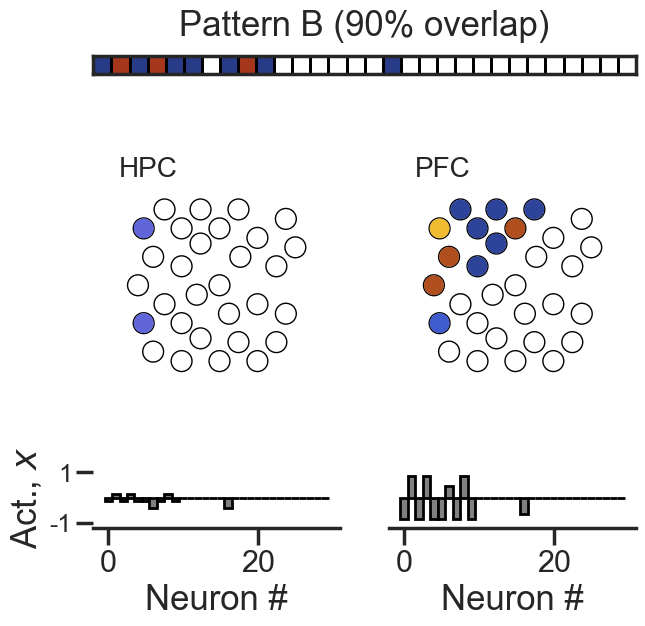

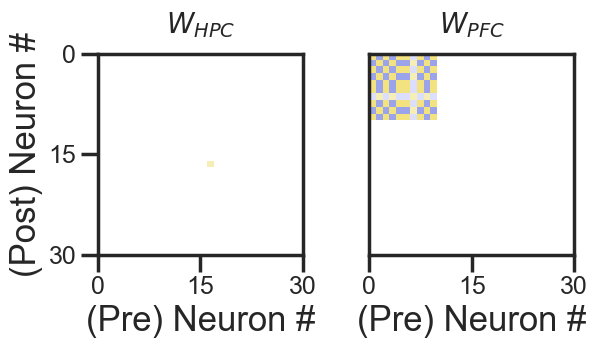

In [14]:
# Figure 4 a1)
fig = plt.figure(figsize=(7, 6.5))
grid = plt.GridSpec(3, 2, hspace=0.8, width_ratios=[1, 1], height_ratios=[1, 2.5, 0.8])

ax_input = fig.add_subplot(grid[0, :])
plot_input('awake1', New_input, 'Pattern B (90% overlap)', n_total, cmap, ax=ax_input)

ax_rnn_hpc = fig.add_subplot(grid[1, 0])
plot_RNN('HPC', 'awake1', neuron_positions, r_final_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

ax_rnn_pfc = fig.add_subplot(grid[1, 1])
plot_RNN('PFC', 'awake1', neuron_positions, r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for HPC
x = np.arange(n_HPC)
ax_bar_hpc = fig.add_subplot(grid[2, 0])
bar_activity(x,r_final_HPC, ax=ax_bar_hpc, ylabel=True)


# Bar graph with states for PFC
ax_bar_pfc = fig.add_subplot(grid[2, 1])
bar_activity(x, r_final_PFC, ax=ax_bar_pfc, ylabel=False)


# Adjust layout and save the figure
plt.savefig('Figure4_a1.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show

# Figure 4 a2)
fig = plt.figure(figsize=(6.5, 4))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights[:n_HPC, :n_HPC], '$W_{HPC}$', 'Trained_wHPC_sleep1.png', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights[n_HPC:, n_HPC:], '$W_{PFC}$', 'Trained_wPFC_sleep1.png', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure4_a2.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()

#### No PFC-to-HPC inhibition 

In [15]:
# Connectivity matrix
weights = np.zeros((n_total, n_total))
weights[n_HPC:,n_HPC:] = PFC_trained_weights_sleep1 # set weights of R2(PFC) to trained weights
print(weights[n_HPC:,n_HPC:])
weights[v2,v1]=0
weights[v1,v2]=0.5

r =  np.zeros(n_total)
r_total = []


#I = get_overlap_array(pattern, 0.9)
#print(I)
I = np.array([-1,  1, -1,  1, -1, -1,  0, -1,  1, -1,  0,  0,  0,  0,  0,  0, -1,  0,
  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
New_input = I.reshape(1,n_HPC)
I=np.concatenate((I,I))

i=0

while True: 
    

    weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC)
    weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)

    r_new = r + dt*hopfield(r, weights, I, n_HPC)
    
    r_total.append(r)
    
    if i>7600:
        print(r_new)
        print(weights[n_HPC:,n_HPC:])
        break
        
    i+=1
    r = r_new
    
r_total = list(zip(*r_total))


r_final_HPC = r[:n_HPC].reshape(1,n_HPC)
r_final_PFC = r[n_HPC:].reshape(1,n_HPC)


[[ 0.10120591 -0.11287484  0.10120591 -0.11287484  0.10120591  0.10120591
  -0.11287484  0.10120591 -0.11287484  0.10120591  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [-0.11287484  0.10166074 -0.11287484  0.10166074 -0.11287484 -0.11287484
   0.10166074 -0.11287484  0.10166074 -0.11287484  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.10120591 -0.11287484  0.10120591 -0.11287484  0.10120591  0.10120591
  -0.11287484  0.10120591 -0.11287484  0.10120591  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.     

[-0.99999673  0.99999995 -0.99999673  0.99999995 -0.99999673 -0.99999673
  0.         -0.99999673  0.99999995 -0.99999673  0.          0.
  0.          0.          0.          0.         -0.99999673  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.94247193  0.9495468  -0.94247193  0.9495468  -0.94247193 -0.94247193
  0.66708684 -0.94247193  0.9495468  -0.94247193  0.          0.
  0.          0.          0.          0.         -0.83119301  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
[[ 0.19933844 -0.25029875  0.19933844 -0.25029875  0.19933844  0.19933844
  -0.18486624  0.19933844 -0.25029875  0.19933844  0.          0.
   0.          0.          0.          0.          0.09092888  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.

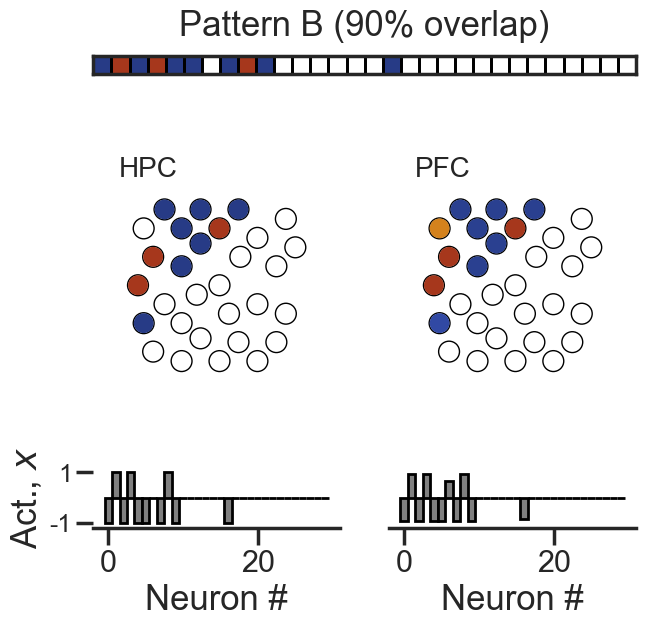

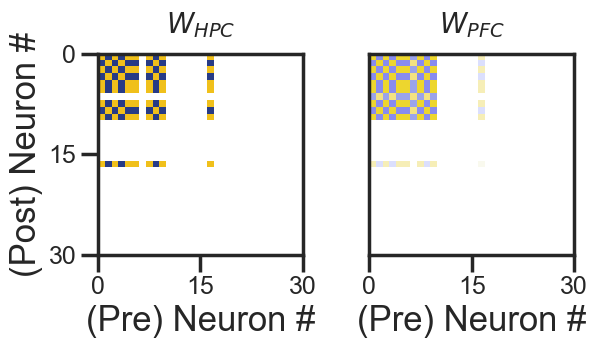

In [16]:
# Figure 4 b1)
fig = plt.figure(figsize=(7, 6.5))
grid = plt.GridSpec(3, 2, hspace=0.8, width_ratios=[1, 1], height_ratios=[1, 2.5, 0.8])

ax_input = fig.add_subplot(grid[0, :])
plot_input('awake1', New_input, 'Pattern B (90% overlap)', n_total, cmap, ax=ax_input)

ax_rnn_hpc = fig.add_subplot(grid[1, 0])
plot_RNN('HPC', 'awake1', neuron_positions, r_final_HPC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_hpc)

ax_rnn_pfc = fig.add_subplot(grid[1, 1])
plot_RNN('PFC', 'awake1', neuron_positions, r_final_PFC, cmap=cmap, circle_radius=0.055, ax=ax_rnn_pfc)

# Bar graph with states for HPC
x = np.arange(n_HPC)
ax_bar_hpc = fig.add_subplot(grid[2, 0])
bar_activity(x,r_final_HPC, ax=ax_bar_hpc, ylabel=True)


# Bar graph with states for PFC
ax_bar_pfc = fig.add_subplot(grid[2, 1])
bar_activity(x, r_final_PFC, ax=ax_bar_pfc, ylabel=False)


# Adjust layout and save the figure
plt.savefig('Figure4_b1.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show

# Figure 4 b2)
fig = plt.figure(figsize=(6.5, 4))
grid = plt.GridSpec(1, 2)

ax_W_hpc = fig.add_subplot(grid[0, 0])
plot_weights( weights[:n_HPC, :n_HPC], '$W_{HPC}$', 'Trained_wHPC_sleep1.png', ax=ax_W_hpc )

ax_W_pfc = fig.add_subplot(grid[0, 1])
plot_weights( weights[n_HPC:, n_HPC:], '$W_{PFC}$', 'Trained_wPFC_sleep1.png', ax=ax_W_pfc, ylabel=False )
plt.tight_layout()
plt.savefig('Figure4_b2.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()

### Generalization of results - examining changes in PFC plasticity and network activity (Figure 5)

#### Create a bunch of different patterns for each degree of overlap

In [28]:
degree_of_overlap = np.around(np.arange(0, 1, 0.1), decimals=1)
new_memories = {}

p = 10  # Number of new inputs to generate

for o in degree_of_overlap:
    inputs = []
    for _ in range(p):
        I = get_overlap_array(pattern, o)  # Generate new input
        inputs.append(I)  # Store new input in the list
    new_memories[o] = inputs  # Store the list of inputs associated with 'o'

    
print("First input with 0.1 overlap:", new_memories[0.1][0])    

First input with 0.1 overlap: [ 0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0. -1.  0.
  0.  1.  0. -1.  1. -1.  0.  0.  0.  1.  0. -1.]


#### Examining sparseness

0.0
[11 14 15 17 19 21 24 25 26 28]
[12 16 17 18 19 21 25 27 28 29]
[13 14 15 16 20 22 25 26 27 28]
[11 12 14 15 18 19 20 22 27 29]
[10 14 15 17 18 19 20 21 22 25]
[11 13 14 15 17 20 23 25 26 27]
[11 12 14 17 19 20 23 24 25 26]
[10 11 15 16 21 22 25 27 28 29]
[12 13 15 17 18 21 22 23 26 29]
[11 15 16 17 18 19 22 23 26 27]
0.1
[ 4 11 12 16 19 21 22 23 27 29]
[ 0 11 12 14 15 18 20 24 27 29]
[ 9 11 13 14 20 21 24 25 27 28]
[ 1 10 16 17 22 23 24 25 28 29]
[ 0 11 13 16 17 18 19 21 26 27]
[ 0 10 13 16 18 20 21 24 26 28]
[ 8 10 11 13 15 20 24 25 27 28]
[ 6 10 11 13 16 17 18 19 20 28]
[ 1 10 11 12 14 16 19 20 22 23]
[ 8 14 16 17 19 21 24 26 28 29]
0.2
[ 0  4 13 16 17 23 24 25 26 29]
[ 2  5 10 16 17 19 22 23 26 27]
[ 3  7 12 15 16 21 23 24 27 29]
[ 1  8 12 15 18 19 20 22 24 29]
[ 0  5 11 15 20 21 24 26 28 29]
[ 6  7 10 12 14 18 20 22 23 25]
[ 6  9 11 12 17 18 21 23 24 25]
[ 2  7 11 15 18 21 22 25 28 29]
[ 0  9 10 11 12 14 15 17 20 25]
[ 0  3 11 13 14 15 17 22 23 29]
0.3
[ 0  1  5 13 15 18 20 21

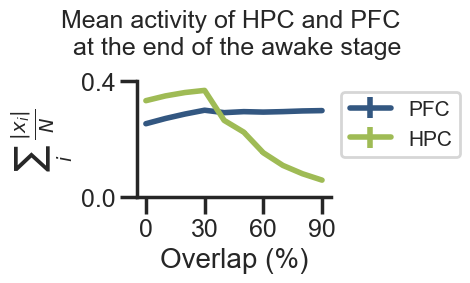

In [29]:
import numpy as np
import matplotlib.pyplot as plt

sparse_HPC = np.zeros(len(degree_of_overlap))
sparse_PFC = np.zeros(len(degree_of_overlap))

std_HPC = np.zeros(len(degree_of_overlap))
std_PFC = np.zeros(len(degree_of_overlap))

all_mean_deltaW = np.zeros(len(degree_of_overlap))
deltaW_PFC = np.zeros(len(degree_of_overlap))


for n,o in enumerate(degree_of_overlap):
    print(o)
    patterns = new_memories[o] # get all patterns for degree of overlap 'o'
    
    fr_HPC=[]
    fr_PFC=[]
    
    for p in range(len(patterns)):
        
        weights = np.zeros((n_total, n_total))
        weights[n_HPC:,n_HPC:] = PFC_trained_weights_sleep1 # set weights of R2(PFC) to trained weights, with memory_A
        weights[v2,v1]=-1 # Inhibitory PFC-to-HPC
        weights[v1,v2]=0.5 # Excitatory HPC-to-PFC
    
        r =  np.zeros(n_total)

        I = patterns[p]
        targeted_neurons = np.nonzero(I)[0]
        print(targeted_neurons)
        I=np.concatenate((I,I))

        i=0

        while True: 

            weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC)
            weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)

            r_new = r + dt*hopfield(r, weights, I, n_HPC)

            if i>7600: # mean activity at the end of the awake stage
                abs_fr = np.abs(r)
                fr_HPC.append(np.mean(abs_fr[:n_HPC]))
                fr_PFC.append(np.mean(abs_fr[n_HPC:]))
                
                break
                  
            i+=1
            r = r_new
            
    sparse_HPC[n]=np.mean(fr_HPC)
    std_HPC[n]=np.std(fr_HPC)
    sparse_PFC[n]=np.mean(fr_PFC)
    std_PFC[n]=np.std(fr_PFC)
        
        
        
from scipy.stats import gaussian_kde

params = {
   'axes.labelsize': 20,
   'legend.fontsize': 20,
   'xtick.labelsize': 18,
   'ytick.labelsize': 18,
    'lines.linewidth': 2,
   'figure.figsize': [3, 3]
   }

plt.rcParams.update(params)

# density plot
import seaborn as sns

plt.figure(figsize=(2.5,1.5))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.errorbar(degree_of_overlap*100,sparse_PFC, yerr=std_PFC, color='#335781', linewidth=4, label='PFC')
plt.errorbar(degree_of_overlap*100,sparse_HPC, yerr=std_HPC, color='#9FBB55', linewidth=4, label='HPC')
plt.xticks([0,30,60,90])
plt.yticks([0,0.4])
plt.legend(bbox_to_anchor=(1, 1), fontsize=15)
plt.ylabel(r'$\sum_i$ $\frac{|x_i|}{N}$', fontsize=20)
plt.xlabel('Overlap (%)')
plt.title('Mean activity of HPC and PFC \n at the end of the awake stage', pad=20, fontsize=18)
plt.savefig('Sparssity_index.png', bbox_inches='tight', dpi=600, transparent=True)
plt.show()




#### Examining PFC connectivity changes

0.0
[11 14 15 17 19 21 24 25 26 28]
[12 16 17 18 19 21 25 27 28 29]
[13 14 15 16 20 22 25 26 27 28]
[11 12 14 15 18 19 20 22 27 29]
[10 14 15 17 18 19 20 21 22 25]
[11 13 14 15 17 20 23 25 26 27]
[11 12 14 17 19 20 23 24 25 26]
[10 11 15 16 21 22 25 27 28 29]
[12 13 15 17 18 21 22 23 26 29]
[11 15 16 17 18 19 22 23 26 27]
0.1
[ 4 11 12 16 19 21 22 23 27 29]
[ 0 11 12 14 15 18 20 24 27 29]
[ 9 11 13 14 20 21 24 25 27 28]
[ 1 10 16 17 22 23 24 25 28 29]
[ 0 11 13 16 17 18 19 21 26 27]
[ 0 10 13 16 18 20 21 24 26 28]
[ 8 10 11 13 15 20 24 25 27 28]
[ 6 10 11 13 16 17 18 19 20 28]
[ 1 10 11 12 14 16 19 20 22 23]
[ 8 14 16 17 19 21 24 26 28 29]
0.2
[ 0  4 13 16 17 23 24 25 26 29]
[ 2  5 10 16 17 19 22 23 26 27]
[ 3  7 12 15 16 21 23 24 27 29]
[ 1  8 12 15 18 19 20 22 24 29]
[ 0  5 11 15 20 21 24 26 28 29]
[ 6  7 10 12 14 18 20 22 23 25]
[ 6  9 11 12 17 18 21 23 24 25]
[ 2  7 11 15 18 21 22 25 28 29]
[ 0  9 10 11 12 14 15 17 20 25]
[ 0  3 11 13 14 15 17 22 23 29]
0.3
[ 0  1  5 13 15 18 20 21

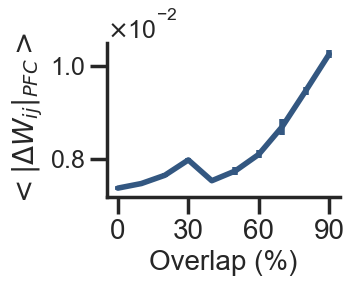

In [30]:
import numpy as np
import matplotlib.pyplot as plt

mean_deltaW = np.zeros(len(degree_of_overlap))
std_deltaW = np.zeros(len(degree_of_overlap))

for n,o in enumerate(degree_of_overlap):
    print(o)
    patterns = new_memories[o] # get all patterns for degree of overlap 'o'
    
    mean_deltaW_PFC=[]
    
    for p in range(len(patterns)):
        
        weights = np.zeros((n_total, n_total))
        weights[n_HPC:,n_HPC:] = PFC_trained_weights_sleep1 # set weights of R2(PFC) to trained weights, with memory_A
        weights[v2,v1]=-1 # Inhibitory PFC-to-HPC
        weights[v1,v2]=0.5 # Excitatory HPC-to-PFC
    
        r =  np.zeros(n_total)

        I = patterns[p]
        targeted_neurons = np.nonzero(I)[0]
        print(targeted_neurons)
        I=np.concatenate((I,I))

        i=0

        while True: 

            weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC)
            weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)

            r_new = r + dt*hopfield(r, weights, I, n_HPC)

            if i>7600:
                abs_deltaW_PFC = np.abs(PFC_trained_weights_sleep1 - weights[n_HPC:,n_HPC:])
                mean_deltaW_PFC.append(np.mean(abs_deltaW_PFC)) # mean over full connectivity for 1 simulation 

                break
        
            i+=1
            r = r_new
            
    mean_deltaW[n]=np.mean(mean_deltaW_PFC) # mean over 10 simulations for a degree of overlap 'o'
    std_deltaW[n]=np.std(mean_deltaW_PFC)        
        
        
from scipy.stats import gaussian_kde

params = {
   'axes.labelsize': 20,
   'legend.fontsize': 20,
   'xtick.labelsize': 20,
   'ytick.labelsize': 18,
    'lines.linewidth': 2,
   'figure.figsize': [3, 3]
   }

plt.rcParams.update(params)

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

plt.figure(figsize=(3, 2))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.errorbar(degree_of_overlap * 100, mean_deltaW, yerr=std_deltaW, color='#335781', linewidth=4)
#plt.plot(degree_of_overlap * 100, mean_deltaW, color='#335781', linewidth=4)
plt.xticks([0, 30, 60, 90])

# Format y-axis ticks in scientific notation
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Set the power limits for scientific notation
plt.gca().yaxis.set_major_formatter(formatter)

plt.ylabel(r'$<|\Delta W_{ij}|_{PFC}>$', fontsize=20)
plt.xlabel('Overlap (%)')
plt.savefig('Changes_PFCconnectivity.png', bbox_inches='tight', dpi=600, transparent=True)
plt.show()


### Figure S2

0.0
[11 14 15 17 19 21 24 25 26 28]


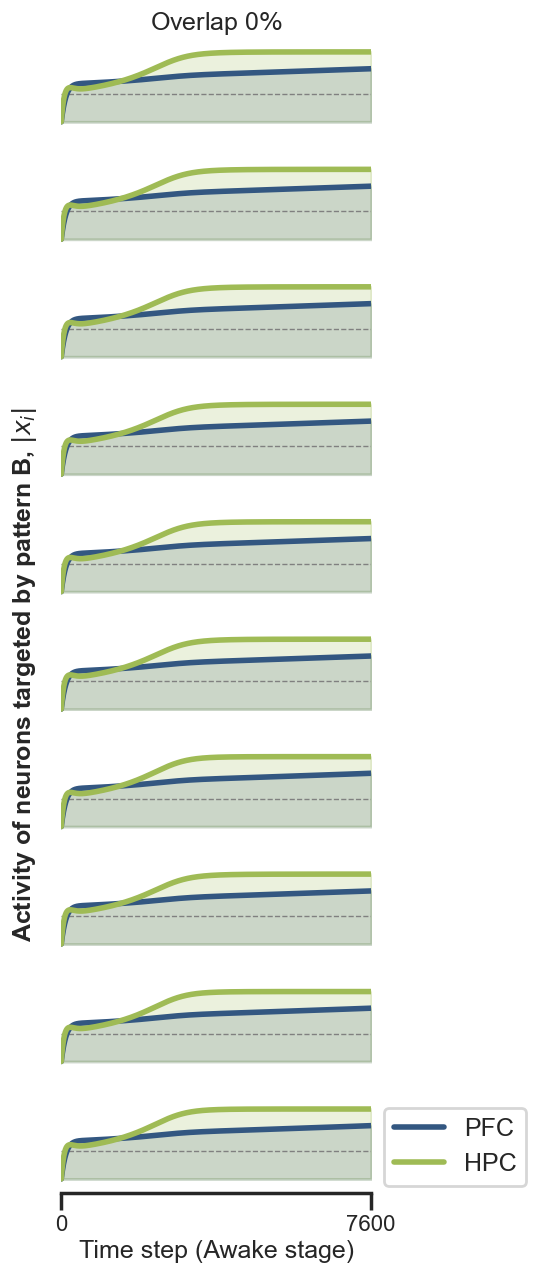

0.9
[ 0  1  2  4  5  6  7  8  9 11]


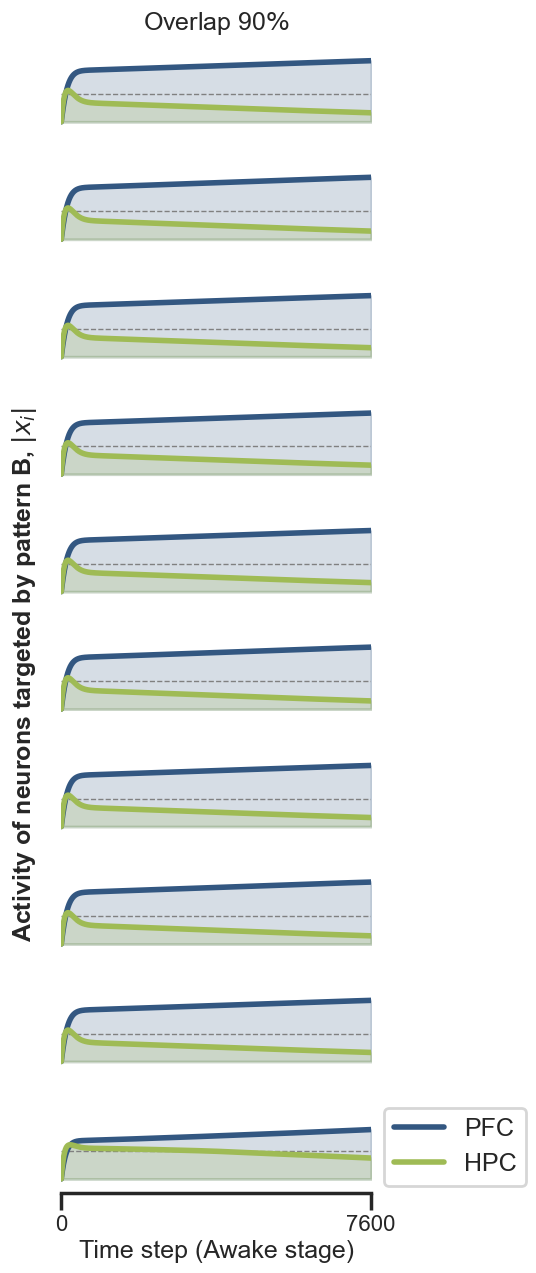

In [33]:
def plot_FigS2(r_total, targeted_neurons, o):
    abs_r_total = np.abs(r_total)
    
    fig, ax = plt.subplots(10, 1, figsize=(4,15))
    
    for j,n in enumerate(targeted_neurons):
        iterations = np.arange(len(r_total[n]))
    
        ax[j].spines['top'].set_visible(False)
        ax[j].spines['right'].set_visible(False)
        ax[j].spines['left'].set_visible(False)
        ax[j].xaxis.tick_bottom()
        ax[j].set_xticks([])
        ax[j].set_yticks([])
        ax[j].set_ylim([-0.2, 1.2])
        ax[j].set_xlim([0,7600])
        ax[j].axhline(y=0.4, color='grey', linestyle='--', linewidth=1)
        ax[j].plot(abs_r_total[n+30][:], color='#335781', linewidth=4, label='PFC')
        ax[j].fill_between(iterations, abs_r_total[n+30][:], 0, alpha=0.2, color='#335781')
        ax[j].plot(abs_r_total[n][:], color='#9FBB55', linewidth=4, label='HPC')
        ax[j].fill_between(iterations, abs_r_total[n][:], 0, alpha=0.2, color='#9FBB55')
        if j==5:
            ax[j].set_ylabel(f'Activity of neurons targeted by pattern B, $|x_i|$', fontsize=18, fontweight='bold')
        if j==0:
            ax[j].set_title(f'Overlap {int(o*100)}$\%$', fontsize=18)
        if j!=9:
            ax[j].spines['bottom'].set_visible(False)
        else:
            ax[j].set_xlabel('Time step (Awake stage)')
            ax[j].set_xticks([0,7600])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.savefig(f'inputBneurons_{o}overlap.png', bbox_inches='tight', dpi=600, transparent=True)
    plt.show()


import numpy as np
import matplotlib.pyplot as plt


for o in [0.0,0.9]:
    print(o)
    patterns = new_memories[o] # get all patterns for degree of overlap 'o'

        
    weights = np.zeros((n_total, n_total))
    weights[n_HPC:,n_HPC:] = PFC_trained_weights_sleep1 # set weights of R2(PFC) to trained weights, with memory_A
    weights[v2,v1]=-1 # Inhibitory PFC-to-HPC
    weights[v1,v2]=0.5 # Excitatory HPC-to-PFC
    
    r =  np.zeros(n_total)
    r_total = []

    I = patterns[0]
    targeted_neurons = np.nonzero(I)[0]
    print(targeted_neurons)
    I=np.concatenate((I,I))

    i=0

    while True: 

        weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC)
        weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)

        r_new = r + dt*hopfield(r, weights, I, n_HPC)
        r_total.append(r)

        if i>7600: # end of the awake stage
            r_total = list(zip(*r_total))
            plot_FigS2(r_total, targeted_neurons, o)
                
            break
                  
        i+=1
        r = r_new
        

### Figure S3

0.0
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  1.  0.  1.
  0.  1.  0.  1.  0.  0. -1.  1. -1.  0. -1.  0.]
[11 14 15 17 19 21 24 25 26 28]
0.1
[ 0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0. -1.  0.
  0.  1.  0. -1.  1. -1.  0.  0.  0.  1.  0. -1.]
[ 4 11 12 16 19 21 22 23 27 29]
0.2
[-1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  1.
  0.  0.  0.  0.  0.  1. -1.  1.  1.  0.  0.  1.]
[ 0  4 13 16 17 23 24 25 26 29]
0.3
[-1.  1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  1.  0. -1.  0.  0.
 -1.  0.  1. -1.  0.  0. -1.  0.  1.  0.  0.  0.]
[ 0  1  5 13 15 18 20 21 24 26]
0.4
[ 0.  0.  0.  0. -1. -1.  1. -1.  0.  0. -1.  0.  0. -1. -1.  1.  0.  0.
  0.  0. -1.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
[ 4  5  6  7 10 13 14 15 20 22]
0.5
[-1.  1.  0.  0. -1. -1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. -1.  0.  0.  0. -1.  0.  0.  1.  0. -1. -1.]
[ 0  1  4  5  8 19 23 26 28 29]
0.6
[-1.  1. -1.  0. -1.  0.  1.  0.  0. -1.  

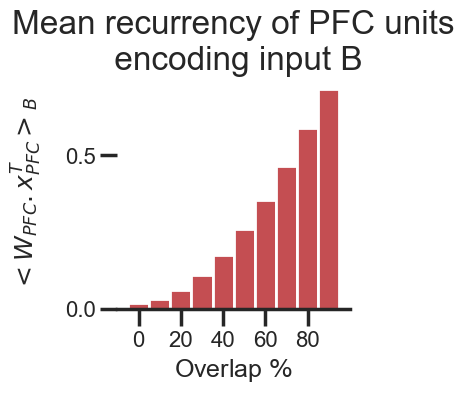

In [35]:
import numpy as np
import matplotlib.pyplot as plt


degree_of_overlap = np.around(np.arange(0, 1, 0.1), decimals=1)
recurrency = {}
firing_rates = {}

for o in degree_of_overlap:
    print(o)
    weights = np.zeros((n_total, n_total))
    weights[n_HPC:,n_HPC:] = PFC_trained_weights_sleep1 # set weights of R2(PFC) to trained weights, with memory_A
    weights[v2,v1]=-1 # Inhibitory PFC-to-HPC
    weights[v1,v2]=0.5 # Excitatory HPC-to-PFC
    
    r =  np.zeros(n_total)
    r_total=[]

    I = new_memories[o][0]
    print(I)
    targeted_neurons = np.nonzero(I)[0]
    print(targeted_neurons)
    I=np.concatenate((I,I))

    i=0

    while i<7600: 
        weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC)
        weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)

        r_new = r + dt*hopfield(r, weights, I, n_HPC)
        r_total.append(r)
        
        if i==800:
            bla = weights[n_HPC:, n_HPC:]@r[n_HPC:]
            recurrency[o]=np.abs(bla[targeted_neurons])
            mean_recurrency[o]=np.mean(recurrency[o])
        
        i+=1
        r = r_new
    firing_rates[o]=r
        
# Calculate the mean
mean_values = [np.mean(eval(f"recurrency[{o}]")) for o in degree_of_overlap]
categories = ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90']

# Create a bar graph with the mean values and customize the plot
plt.bar(range(len(categories)), mean_values, color='r', width=1)
plt.xticks(range(0, len(categories), 2), categories[::2])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tick_params(axis='x', which='both', bottom=True)
plt.yticks([0.0, 0.5])

plt.title('Mean recurrency of PFC units\n encoding input B')
plt.xlabel('Overlap $\%$')
plt.ylabel('$<W_{PFC}.x^T_{PFC}>_B$', labelpad=15)
plt.savefig('Recurrency.png', bbox_inches='tight', dpi=600, transparent=True)
plt.show()



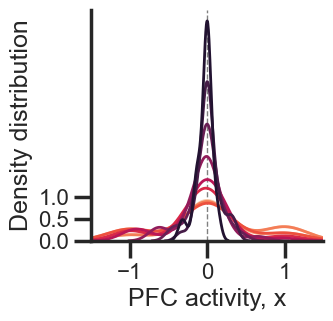

In [37]:
from scipy.stats import gaussian_kde

params = {
   'axes.labelsize': 18,
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16,
    'lines.linewidth': 2,
   'figure.figsize': [3, 3]
   }



plt.rcParams.update(params)

# density plot
import seaborn as sns

fig, ax = plt.subplots()  # Create a figure and Axes object

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove the left and bottom ticks
ax.yaxis.tick_left()
ax.xaxis.tick_bottom()
plt.axvline(x=0, color='grey', linestyle='--', linewidth=1) 
for n,o in enumerate(degree_of_overlap):
    color = sns.color_palette("rocket_r", 10)[n]  # Select color from Seaborn palette
    sns.kdeplot(firing_rates[o][n_HPC:], color=color)

plt.xlabel('PFC activity, x')
#plt.xticks([1, 3, 5, 7, 9])
plt.xlim(-1.5, 1.5)
plt.yticks([0,0.5,1])
plt.ylabel('Density distribution')
plt.savefig('Sparseness_PFC.png', bbox_inches='tight', dpi=600, transparent=True)
plt.show()



## Linking and pattern separation

### Figure S5

In [38]:
'''
Calculate final connectivity for different degrees of overlap, without sleep
'''

degree_of_overlap = np.around(np.arange(0, 1, 0.1), decimals=1)
trained_weights_without_sleep = {}

for o in degree_of_overlap:
    print(o)
    patterns = new_memories[o]  # Get all patterns for degree of overlap 'o'
    for p in range(len(patterns)):
        
        weights = np.zeros((n_total, n_total))
        weights[n_HPC:, n_HPC:] = PFC_trained_weights_sleep1  # set weights of R2(PFC) to trained weights, with memory_A
        weights[v2, v1] = -1
        weights[v1, v2] = 0.5
    
        r = np.zeros(n_total)

        I = patterns[p]
        I = np.concatenate((I, I))

        i = 0

        while True: 

            weights[:n_HPC, :n_HPC] += dt * hebbian(weights[:n_HPC, :n_HPC], r[:n_HPC], learn_HPC, decay_HPC)
            weights[n_HPC:, n_HPC:] += dt * hebbian(weights[n_HPC:, n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)

            r_new = r + dt * hopfield(r, weights, I, n_HPC)
    
            if i > 7600:
                trained_weights_without_sleep.setdefault(o, []).append(weights)  # Store weights associated with 'o'
                break
        
            i += 1
            r = r_new

        r_final_HPC = r[:n_HPC].reshape(1, n_HPC)
        r_final_PFC = r[n_HPC:].reshape(1, n_HPC)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [39]:
'''
Calculate final connectivity for different degrees of overlap, with sleep (following previous cell). 

In practice, this is what I previously called Consolidation (or sleep) phase
'''

v1 = [i for i in range(n_HPC, n_total)]
v2 = [i for i in range(0, n_HPC)]

trained_weights_with_sleep = {}


for o in degree_of_overlap:
    
    print(o)
    for p in range(len(patterns)):
    
        weights = np.copy(trained_weights_without_sleep[o][p])

        for j in range(7):
        
            # Uncoupled phase
            r = np.zeros(n_total)
            r[:n_HPC] =  np.random.normal(loc=0, scale=0.1, size=n_HPC)

            i=0

            # Coupled phase
            while True:   

                if i>9000:
                    weights[v1,v2]=1
                    weights[v2,v1]=-1
                else:
                    weights[v1,v2]=0
                    weights[v2,v1]=0
    
    
                weights[:n_HPC,:n_HPC] += dt*hebbian(weights[:n_HPC,:n_HPC], r[:n_HPC], learn_HPC, decay_HPC) 
                weights[n_HPC:,n_HPC:] += dt*hebbian(weights[n_HPC:,n_HPC:], r[n_HPC:], learn_PFC, decay_PFC)
    
                r_new = r + dt*hopfield(r, weights, 0, n_HPC)
    
                if i>9900:
                    break
        
                i+=1
                r = r_new
        trained_weights_with_sleep.setdefault(o, []).append(weights)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [40]:
'''
Recall of memory B WITHOUT SLEEP

For each degree of overlap, start network with respective trained_weights_without_sleep.
For each network connectivity state, calculate input that partially overlaps with memory B. 
Check how many PFC cells are activated at end of each simulation. Normalize it? 

'''

import pickle

num_simulations = 10
indices_memoryA = np.where(np.logical_or(pattern[:n_HPC] == -1, pattern[:n_HPC] == 1))[0]


for p in range(len(patterns)):
    
    # Initialize a list to store recalll_B dictionaries for each simulation
    recall_B_list = []
    recall_AB_list = []
    for j in range(num_simulations):
        recall_B = {}
        recall_AB = {}

        weights = np.zeros((n_total, n_total))

        for o in degree_of_overlap:
            weights[n_HPC:,n_HPC:] = trained_weights_without_sleep[o][p][n_HPC:, n_HPC:] # set weights of R2(PFC) to trained weights
            recall_units_B = []
            recall_units_AB = []
    
            for number_act_units in range(10):
                r = np.zeros(n_total)
                indices_memoryB = np.where(np.logical_or(new_memories[o][p] == -1, new_memories[o][p] == 1))[0]
                indices_memoryAB = np.concatenate((indices_memoryA, indices_memoryB))

                I = new_memories[o][p]
                new_I = get_recall_input(I, number_act_units)
                new_I = np.concatenate((new_I, new_I))

                i=0
                while True:  

                    r_new = r + dt*hopfield(r, weights, new_I, n_HPC)   
    
                    if i>7600:
                        count_B = sum(1 for idx in indices_memoryB if abs(r_new[idx+n_HPC]) > 0.2)
                        recall_units_B.append(count_B)
                                        
                        count_AB = sum(1 for idx in indices_memoryAB if abs(r_new[idx+n_HPC]) > 0.2)
                        recall_units_AB.append(count_AB)        
            
                        break
        
                    i+=1
                    r = r_new

                recall_B[o]=recall_units_B
                recall_AB[o]=recall_units_AB
            recall_B_list.append(recall_B)
            recall_AB_list.append(recall_AB)
            
    f = open(f'recall_B_noSleep_{p}.pkl', 'wb')
    pickle.dump(recall_B_list, f)
    f.close()
    
    f = open(f'recall_AB_noSleep_{p}.pkl', 'wb')
    pickle.dump(recall_AB_list, f)
    f.close()
            

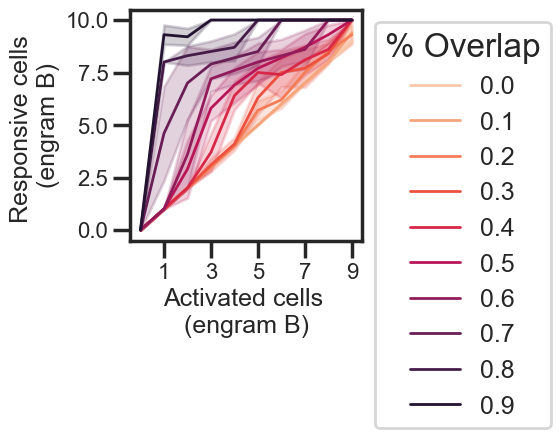

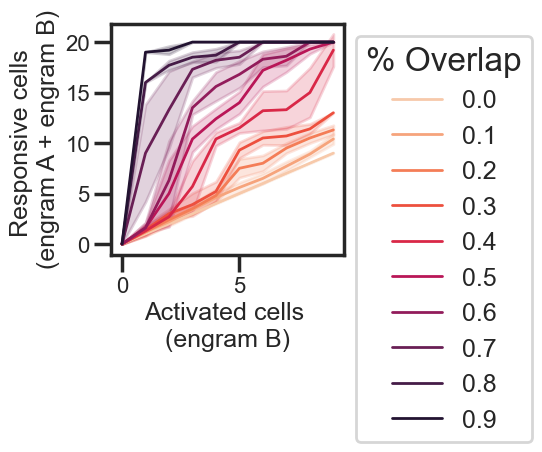

In [41]:
import seaborn as sns

for p in range(len(patterns)):
    f = open(f'recall_B_noSleep_{p}.pkl', 'rb')
    recall_B_list = pickle.load(f)
    f.close()
    

    mean_recall_B={}
    std_recall_B={}

    for o in degree_of_overlap:
        recall_values = np.array([recall_B[o] for recall_B in recall_B_list])  # Combine arrays from all simulations
        mean_recall_B[o] = np.mean(recall_values, axis=0)  # Calculate mean along axis 0 (across simulations)
        std_recall_B[o] = np.std(recall_values, axis=0)   # Calculate std along axis 0 (across simulations)

    
    f1 = open(f'meanB_noSleep_{p}.pkl', 'wb')
    f2 = open(f'stdB_noSleep_{p}.pkl', 'wb')    
    pickle.dump(mean_recall_B, f1)
    pickle.dump(std_recall_B, f2)
    f1.close()
    f2.close()   

        
# Plot the mean and standard deviation arrays
# Plot the mean and shaded area between mean ± std
x_range = range(len(mean_recall_B[o]))


plt.figure()
for n,o in enumerate(degree_of_overlap):
    color = sns.color_palette("rocket_r", 10)[n]  # Select color from Seaborn palette
    plt.plot(mean_recall_B[o], label=f'{o}', color=color)
    plt.fill_between(x_range,
        mean_recall_B[o] + std_recall_B[o],
        mean_recall_B[o] - std_recall_B[o],
        color=color,
        alpha=0.2
    )
  
plt.xlabel('Activated cells \n(engram B)')
plt.xticks([1, 3, 5, 7, 9])
plt.ylabel('Responsive cells \n(engram B)')
legend = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
legend.set_title('% Overlap')
plt.show()




for p in range(len(patterns)):
    f = open(f'recall_AB_noSleep_{p}.pkl', 'rb')
    recall_AB_list = pickle.load(f)
    f.close()


    mean_recall_AB={}
    std_recall_AB={}

    for o in degree_of_overlap:
        recall_values = np.array([recall_AB[o] for recall_AB in recall_AB_list])  # Combine arrays from all simulations
        mean_recall_AB[o] = np.mean(recall_values, axis=0)  # Calculate mean along axis 0 (across simulations)
        std_recall_AB[o] = np.std(recall_values, axis=0)   # Calculate std along axis 0 (across simulations)
        
    f1 = open(f'meanAB_noSleep_{p}.pkl', 'wb')
    f2 = open(f'stdAB_noSleep_{p}.pkl', 'wb')    
    pickle.dump(mean_recall_AB, f1)
    pickle.dump(std_recall_AB, f2)
    f1.close()
    f2.close()        

# Plot the mean and standard deviation arrays
# Plot the mean and shaded area between mean ± std
x_range = range(len(mean_recall_AB[o]))


plt.figure()
for n,o in enumerate(degree_of_overlap):
    color = sns.color_palette("rocket_r", 10)[n]  # Select color from Seaborn palette
    plt.plot(mean_recall_AB[o], label=f'{o}', color=color)
    plt.fill_between(x_range,
        mean_recall_AB[o] + std_recall_AB[o],
        mean_recall_AB[o] - std_recall_AB[o],
        color=color,
        alpha=0.2
    )
  
plt.xlabel('Activated cells \n(engram B)')
plt.ylabel('Responsive cells \n(engram A + engram B)')
legend = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
legend.set_title('% Overlap')
plt.show()


In [42]:
'''
Recall of memory B and AB WITH SLEEP

'''

import pickle

num_simulations = 10
indices_memoryA = np.where(np.logical_or(pattern[:n_HPC] == -1, pattern[:n_HPC] == 1))[0]

for p in range(len(patterns)):
    
    # Initialize a list to store recalll_B dictionaries for each simulation
    recall_B_list = []
    recall_AB_list = []
    for j in range(num_simulations):
        recall_B = {}
        recall_AB = {}

        weights = np.zeros((n_total, n_total))

        for o in degree_of_overlap:
            weights[n_HPC:,n_HPC:] = trained_weights_with_sleep[o][p][n_HPC:, n_HPC:] # set weights of R2(PFC) to trained weights
            recall_units_B = []
            recall_units_AB = []
    
            for number_act_units in range(10):
                r = np.zeros(n_total)
                indices_memoryB = np.where(np.logical_or(new_memories[o][p] == -1, new_memories[o][p] == 1))[0]
                indices_memoryAB = np.concatenate((indices_memoryA, indices_memoryB))

                I = new_memories[o][p]
                new_I = get_recall_input(I, number_act_units)
                new_I = np.concatenate((new_I, new_I))

                i=0
                while True:  

                    r_new = r + dt*hopfield(r, weights, new_I, n_HPC)   
    
                    if i>7600:
                        count_B = sum(1 for idx in indices_memoryB if abs(r_new[idx+n_HPC]) > 0.2)
                        recall_units_B.append(count_B)
                                        
                        count_AB = sum(1 for idx in indices_memoryAB if abs(r_new[idx+n_HPC]) > 0.2)
                        recall_units_AB.append(count_AB)        
            
                        break
        
                    i+=1
                    r = r_new

                recall_B[o]=recall_units_B
                recall_AB[o]=recall_units_AB
            recall_B_list.append(recall_B)
            recall_AB_list.append(recall_AB)
            
    f = open(f'recall_B_Sleep_{p}.pkl', 'wb')
    pickle.dump(recall_B_list, f)
    f.close()
    
    f = open(f'recall_AB_Sleep_{p}.pkl', 'wb')
    pickle.dump(recall_AB_list, f)
    f.close()
            

In [43]:
import seaborn as sns

for p in range(len(patterns)):
    f = open(f'recall_B_Sleep_{p}.pkl', 'rb')
    recall_B_list = pickle.load(f)
    f.close()


    mean_recall_sleep_B={}
    std_recall_sleep_B={}

    for o in degree_of_overlap:
        recall_values = np.array([recall_B[o] for recall_B in recall_B_list])  # Combine arrays from all simulations
        mean_recall_sleep_B[o] = np.mean(recall_values, axis=0)  # Calculate mean along axis 0 (across simulations)
        std_recall_sleep_B[o] = np.std(recall_values, axis=0)   # Calculate std along axis 0 (across simulations)

    f1 = open(f'meanB_Sleep_{p}.pkl', 'wb')
    f2 = open(f'stdB_Sleep_{p}.pkl', 'wb')    
    pickle.dump(mean_recall_sleep_B, f1)
    pickle.dump(std_recall_sleep_B, f2)
    f1.close()
    f2.close()        
        
# Plot the mean and standard deviation arrays
# Plot the mean and shaded area between mean ± std
x_range = range(len(mean_recall_sleep_B[o]))


plt.figure()
for n,o in enumerate(degree_of_overlap):
    color = sns.color_palette("rocket_r", 10)[n]  # Select color from Seaborn palette
    plt.plot(mean_recall_sleep_B[o], label=f'{o}', color=color)
    plt.fill_between(x_range,
        mean_recall_sleep_B[o] + std_recall_sleep_B[o],
        mean_recall_sleep_B[o] - std_recall_sleep_B[o],
        color=color,
        alpha=0.2
    )
  
plt.xlabel('Activated cells \n(engram B)')
plt.xticks([1, 3, 5, 7, 9])
plt.ylabel('Responsive cells \n(engram B)')
legend = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
legend.set_title('% Overlap')
plt.show()



for p in range(len(patterns)):
    f = open(f'recall_AB_Sleep_{p}.pkl', 'rb')
    recall_AB_list = pickle.load(f)
    f.close()


    mean_recall_sleep_AB={}
    std_recall_sleep_AB={}

    for o in degree_of_overlap:
        recall_values = np.array([recall_AB[o] for recall_AB in recall_AB_list])  # Combine arrays from all simulations
        mean_recall_sleep_AB[o] = np.mean(recall_values, axis=0)  # Calculate mean along axis 0 (across simulations)
        std_recall_sleep_AB[o] = np.std(recall_values, axis=0)   # Calculate std along axis 0 (across simulations)

    f1 = open(f'meanAB_Sleep_{p}.pkl', 'wb')
    f2 = open(f'stdAB_Sleep_{p}.pkl', 'wb')    
    pickle.dump(mean_recall_sleep_AB, f1)
    pickle.dump(std_recall_sleep_AB, f2)
    f1.close()
    f2.close()     
        
# Plot the mean and standard deviation arrays
# Plot the mean and shaded area between mean ± std
x_range = range(len(mean_recall_sleep_AB[o]))


plt.figure()
for n,o in enumerate(degree_of_overlap):
    color = sns.color_palette("rocket_r", 10)[n]  # Select color from Seaborn palette
    plt.plot(mean_recall_sleep_AB[o], label=f'{o}', color=color)
    plt.fill_between(x_range,
        mean_recall_sleep_AB[o] + std_recall_sleep_AB[o],
        mean_recall_sleep_AB[o] - std_recall_sleep_AB[o],
        color=color,
        alpha=0.2
    )
  
plt.xlabel('Activated cells \n(engram B)')
plt.ylabel('Responsive cells \n(engram A + engram B)')
legend = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
legend.set_title('% Overlap')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'recall_B_Sleep_4.pkl'

In [ ]:
recall_noSleep = []
recall_Sleep = []
linking_noSleep = []
linking_Sleep = []

for p in range(len(patterns)):
    f = open(f'meanB_noSleep_{p}.pkl', 'rb')
    mean_recall_B = pickle.load(f)
    f.close()    

    recall_quantified_no_sleep = []

    for o in degree_of_overlap:
        indices = np.where(mean_recall_B[o]==10)[0]
    
        if len(indices)>0:
            recall_quantified_no_sleep.append(1/indices[0])
        else:
            recall_quantified_no_sleep.append(0)
    
    recall_noSleep.append(recall_quantified_no_sleep)

    
    f = open(f'meanB_Sleep_{p}.pkl', 'rb')
    mean_recall_sleep_B = pickle.load(f)
    f.close()    

    recall_quantified_sleep = []

    for o in degree_of_overlap:
    
        indices = np.where(mean_recall_sleep_B[o]==10)[0]
    
        if len(indices)>0:
            recall_quantified_sleep.append(1/indices[0])
        else:
            recall_quantified_sleep.append(0)
            
    recall_Sleep.append(recall_quantified_sleep)
        
    f = open(f'meanAB_noSleep_{p}.pkl', 'rb')
    mean_recall_AB = pickle.load(f)
    f.close()    
        
    linking_quantified_no_sleep = []

    for o in degree_of_overlap:
    
        indices = np.where(mean_recall_AB[o]==20)[0]
    
        if len(indices)>0:
            linking_quantified_no_sleep.append(1/indices[0])
        else:
            linking_quantified_no_sleep.append(0)
    linking_noSleep.append(linking_quantified_no_sleep)
    
    f = open(f'meanAB_Sleep_{p}.pkl', 'rb')
    mean_recall_AB = pickle.load(f)
    f.close()    
        
    linking_quantified_sleep = []

    for o in degree_of_overlap:
    
        indices = np.where(mean_recall_sleep_AB[o]==20)[0]
    
        if len(indices)>0:
            linking_quantified_sleep.append(1/indices[0])
        else:
            linking_quantified_sleep.append(0)
            
    linking_Sleep.append(linking_quantified_sleep)

In [ ]:
recall_noSleep_array = np.array(recall_noSleep)
mean_recall_noSleep = np.mean(recall_noSleep_array, axis=0)
std_recall_noSleep = np.std(recall_noSleep_array, axis=0)

recall_Sleep_array = np.array(recall_Sleep)
mean_recall_Sleep = np.mean(recall_Sleep_array, axis=0)
std_recall_Sleep = np.std(recall_Sleep_array, axis=0)

linking_noSleep_array = np.array(linking_noSleep)
mean_linking_noSleep = np.mean(linking_noSleep_array, axis=0)
std_linking_noSleep = np.std(linking_noSleep_array, axis=0)

linking_Sleep_array = np.array(linking_Sleep)
mean_linking_Sleep = np.mean(linking_Sleep_array, axis=0)
std_linking_Sleep = np.std(linking_Sleep_array, axis=0)




# Plot the mean_recall with std_recall as error bars
plt.errorbar(range(len(mean_recall_noSleep)), mean_recall_noSleep, yerr=std_recall_noSleep,  label='Mean Recall with Std Deviation')
plt.legend()


In [ ]:
"""Linking and pattern separation"""

print(linking_quantified_no_sleep)
print(linking_quantified_sleep)
print(recall_quantified_no_sleep)
print(recall_quantified_sleep)


params = {
   'axes.labelsize': 20,
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16,
   'figure.figsize': [3, 3]
   }
plt.rcParams.update(params)

fig, ax1 = plt.subplots() 

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.get_xaxis().tick_bottom()
ax1.grid(linestyle='--', linewidth=0.9, color='0.9')
ax1.set_yticks([0.0, 0.5, 1.0])
ax1.set_ylabel('Reciprocal\n recall threshold', color = 'black') 
ax1.set_xlabel('% Overlap', color = 'black') 
ax1.tick_params(width=1, length=5)

ax1.errorbar(degree_of_overlap*100, mean_linking_Sleep, yerr=std_linking_Sleep,  color = 'black', linewidth=3, linestyle='--', label='Engram A+B')
ax1.errorbar(degree_of_overlap*100, mean_recall_Sleep, yerr=std_recall_Sleep,  color = 'black', linewidth=2, label='Engram B')

 
ax1.set_xticks([0,40, 90])
ax1.set_yticks([0,0.35])
ax1.set_xticklabels(ax1.get_xticks(), rotation=45)
 

ax1.legend(loc=0, bbox_to_anchor=(2.1, 1))
plt.savefig('Linking_vs_recall_plot2.png', bbox_inches='tight', dpi=600, transparent=True)
plt.show()



fig, ax1 = plt.subplots() 

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.get_xaxis().tick_bottom()
ax1.grid(linestyle='--', linewidth=0.9, color='0.9')
ax1.set_yticks([0.0, 0.5, 1.0])
ax1.set_ylabel('Reciprocal\n recall threshold', color = 'black') 
ax1.set_xlabel('% Overlap', color = 'black') 
ax1.tick_params(width=1, length=5)

ax1.errorbar(degree_of_overlap*100, mean_linking_noSleep, yerr=std_linking_noSleep,  color = 'black', linewidth=3, linestyle='--', label='Engram A+B')
ax1.errorbar(degree_of_overlap*100, mean_recall_noSleep, yerr=std_recall_noSleep,  color = 'black', linewidth=2, label='Engram B')

   
ax1.set_xticks([0,20, 40, 90])
ax1.set_yticks([0,0.35])
ax1.set_xticklabels(ax1.get_xticks(), rotation=45)


ax1.legend(loc=0, bbox_to_anchor=(2.1, 1))
plt.savefig('Linking_vs_recall_plot1.png', bbox_inches='tight', dpi=600, transparent=True)
plt.show()
